# Predicción Univariada y Multivariada de los Principales Índices Financieros del Mundo

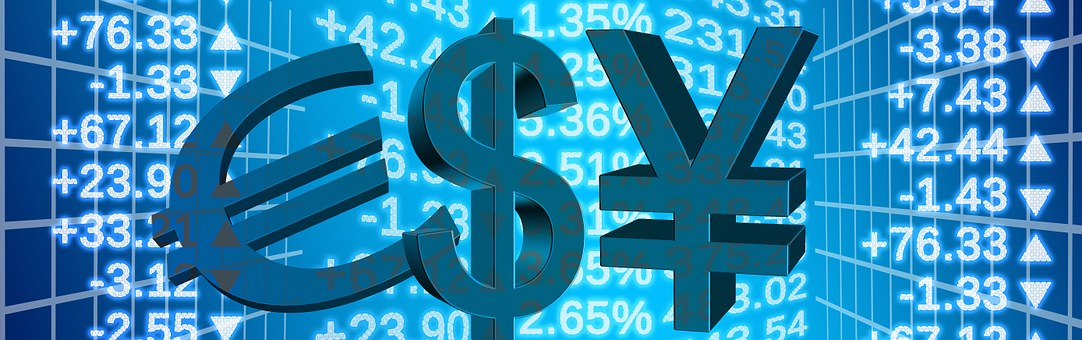

In [1]:
from IPython.display import Image
Image(filename='./img/imagenStock.jpg' ,  width= 1280)

## <ins>Carga del Dataset e Importación de librerías<ins>

#### Importación Librerías

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VECM
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
plt.rcParams['figure.figsize'] = (15, 5)
import tensorflow as tf
from tensorflow import keras
import sys
from scipy.interpolate import interp1d
import missingno as msno
import math

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### Carga Dataset

In [5]:
df_ = pd.read_csv("inputs/dataset.csv", index_col=0, parse_dates=True, dayfirst=True)
#Los argumentos index_col=0 y parse_dates se emplean para que la columna FECHA sea usada como índice

In [6]:
df_.head()

MERV     BVSP        GSPC          NDX         FTSE  \
FECHA                                                                   
1997-07-02  824.109985  13260.0  904.030029   975.929993  4751.399902   
1997-07-03  831.440002  13285.0  916.919983   986.520020  4831.700195   
1997-07-04  837.950012  13494.0         NaN          NaN  4812.799805   
1997-07-07  841.690002  13502.0  912.200012   991.039978  4810.700195   
1997-07-08  846.330017  13617.0  918.750000  1005.809998  4758.500000   

                  GDAXI         FCHI         N225          HSI     SSEC  \
FECHA                                                                     
1997-07-02  3867.530029  2909.500000  20196.41992          NaN  1199.06   
1997-07-03  3939.729980  2937.000000  20121.41016  15055.70020  1150.62   
1997-07-04  3946.729980  2934.500000  19968.00000  14823.00000  1159.34   
1997-07-07  4003.350098  2947.699951  19705.16992  14858.59961  1096.82   
1997-07-08  4030.100098  2929.800049  19853.89063  14792.20020  1109.67   

                  BSESN  DEXARUS  DEXBZUS  DEXUSUK  DEXUSEU  DEXJPUS  DEXHKUS  \
FECHA                                                                           
1997-07-02  4333.899902   0.9998   1.0767   1.6670   1.1223   114.52   7.7472   
1997-07-03  4323.459961   0.9994   1.0778   1.6885   1.1242   113.46   7.7445   
1997-07-04  4323.819824   0.9995      NaN      NaN   1.1230      NaN      NaN   
1997-07-07  4291.450195   0.9998   1.0779   1.6870   1.1226   112.60   7.7428   
1997-07-08  4306.390137   0.9999   1.0790   1.6885   1.1180   112.76   7.7436   

            DEXCHUS  DOLAR_BLUE  
FECHA                            
1997-07-02   8.3210         NaN  
1997-07-03   8.3214         NaN  
1997-07-04      NaN         NaN  
1997-07-07   8.3218         NaN  
1997-07-08   8.3219         NaN

#### Variables

- __FECHA__: se la usa como índice del _pandasDataFrame_

##### Índices (Valores al cierre de cada día):

- __MERV__: Merval (Argentina)
- __BVSPC__: Bovespa (Brasil)
- __GSPC__: Standard & Poors 500 (Estados Unidos)
- __NDX__: Nasdaq 100 (Estados Unidos)
- __FTSE__: FTSE 100 (Reino Unido)
- __GDAXI__: DAX 30 (Alemania)
- __FCHI__: CAC 40 (Francia)
- __N225__: Nikkei 225 (Japón)
- __HSI__: Hang Seng (China)
- __SSEC__: Shanghai Composite (China)
- __BSESN__: Bombay Stock Exchange (India)

##### Tipos de cambio:

- __DEXARUS__: cantidad de pesos argentinos necesarios para adquir un dólar estadounidense
- __DEXBZUS__: cantidad de reales necesarios para adquir un dólar estadounidense
- __DEXUSUK__: cantidad de dólares estadounidenses necesarios para adquir una libra esterlina
- __DEXUSEU__: cantidad de dólares estadounidenses necesarios para adquir un euro
- __DEXJPUS__: cantidad de yenes necesarios para adquir un dólar estadounidense
- __DEXHKUS__: cantidad de dólares hongkonenses necesarios para adquir un dólar estadounidense
- __DEXCHUS__: cantidad de yuanes chinos necesarios para adquirir un dólar estadounidense
- __DOLAR_BLUE__: serie de dolar blue, que se puede usar para corregir __DEXARUS__ en épocas de cepo cambiario. Surge de la combinación de dos series, una para el período 28/10/2011 - 16/12/2015 y otra para el período 01/09/2019 - 08/05/2020.

## <ins>Práctico N°1: Análisis y Visualización de Datos<ins>

El objetivo general de este práctico fue realizar un análisis exploratorio profundo de __los índices__ del dataset.
Se realizaron una serie de pasos para explorar las series en forma individual y conjunta por medio de medidas descriptivas y visualizaciones, con la finalidad de confeccionar un informe detallado sobre los índices analizados que luego sirvió de base para modelar las series y hacer pronósticos.

Se trabajó con el valor de los índices en crudo, es decir, no se realizó ninguna conversión como para que la comparación entre ellos sea más significativa. Sin embargo, se pudo inferir sobre su comportamiento y evolución en el periodo de estudio (de julio de 1997 a mayo del corriente año)

Se calcularon las medidas de estadística descriptiva para cada serie: media, varianza y desviación standar. Además se graficaron los histogramas y boxplots correspondientes. Del primer gráfico se pudo concluir que las distribuciones de los valores están lejos de seguir una distribución normal. Por otra parte, los boxplots se utilizaron para confirmar que no hay gran cantidad de valores outliers y no hay estacionalidad a lo largo de los años. El proceso de detección de outliers en series de tiempo es complejo, ya que las distribuciones de los índices son diferentes año a año, por lo que no es posible utilizar el método tradicional para detectar los valores atípicos. Como se muestra aquí, se utilizaron dos métodos para su posible detección.

Con respecto a la existencia de estacionalidad, de los gráficos de media y desviación estandar se puede afirmar que estos valores no son constantes en el tiempo, por lo tanto no es posible hablar de series estacionales. Sin embargo, en el caso de algunos índices como en el Merval al comienzo del periodo de estudio, se podría divisar cierta estacionalidad. La conclusión de falta de estacionalidad se ve reforzada al ver los gráficos de las funciones de autocorrelación y autocorrelación parcial.

#### Paso 1: Identificar Tipo de Variable y Periodo de Tiempo bajo Análisis

En este primer práctico, se trabajó solamente con las columnas correspondientes a índices del dataset por lo que se eliminaron las otras columnas. Además, se ordenó el índice del dataframe:

In [7]:
df = df_[df_.columns[:11]]
df = df.loc[df.index.sort_values()]

Se observó que todas las variables a utilizar son del tipo numéricas:

In [8]:
df.dtypes

MERV     float64
BVSP     float64
GSPC     float64
NDX      float64
FTSE     float64
GDAXI    float64
FCHI     float64
N225     float64
HSI      float64
SSEC     float64
BSESN    float64
dtype: object

Por otra parte, el tipo de dato del índice (FECHA) es `<M8[ns]` lo que hace referencia a una fecha `datetime64[ns]`:

In [9]:
df.index.dtype

dtype('<M8[ns]')

In [10]:
print(f'El periodo de análisis es de {df.index.min()} a {df.index.max()}.')

El periodo de análisis es de 1997-07-02 00:00:00 a 2020-05-08 00:00:00.


#### Paso 2: Indagar sobre la existencia de valores faltantes

Como primer paso, se encontró la cantidad de valores faltantes por columna ordenados de mayor a menor:

In [11]:
df.isnull().sum().sort_values(ascending=False)

SSEC     494
MERV     442
N225     438
BSESN    417
HSI      408
BVSP     384
NDX      286
GSPC     286
FTSE     277
GDAXI    245
FCHI     211
dtype: int64

Se confirmó la sospecha de que no existían observaciones para los días correspondientes al fin de semana:

In [12]:
df[df.index.dayofweek>=5]

MERV  BVSP  GSPC  NDX  FTSE  GDAXI  FCHI  N225  HSI     SSEC  \
FECHA                                                                      
2006-02-05   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN  1258.05   
2010-02-06   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN      NaN   
2011-12-24   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN      NaN   
2011-12-31   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN      NaN   
2012-01-07   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN      NaN   
...          ...   ...   ...  ...   ...    ...   ...   ...  ...      ...   
2020-04-19   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN      NaN   
2020-04-25   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN      NaN   
2020-04-26   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN      NaN   
2020-05-02   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN      NaN   
2020-05-03   NaN   NaN   NaN  NaN   NaN    NaN   NaN   NaN  NaN      NaN   

            BSESN  
FECHA              
2006-02-05    NaN  
2010-02-06    NaN  
2011-12-24    NaN  
2011-12-31    NaN  
2012-01-07    NaN  
...           ...  
2020-04-19    NaN  
2020-04-25    NaN  
2020-04-26    NaN  
2020-05-02    NaN  
2020-05-03    NaN  

[74 rows x 11 columns]

#### Paso 3: Analizar la distribución de las series mediante gráficos y medidas de estadística descriptiva

Como primera aproximación, se calcularon para cada variable, las medidas de estadística descriptiva más habituales: Media, Varianza, Coeficiente de Variación, Índice de Simetría de Pearson y Coeficiente de Curtosis. 

In [13]:
for col in df.columns:
    print('\n',col,'\n')
    mean = df[col].mean()
    median = df[col].median()
    var = df[col].var()
    std = df[col].std()
    coef = std/mean
    indice_simetria_pearson = 3*(mean - median)/std
    coef_curtosis = df[col].kurt()
    
    print('MEDIA: ', round(mean,2))
    print('VARIANZA: ', round(var,2))
    print('COEF. DE VARIACION: ', round(coef,4), '=>', round(coef * 100,2), '%')
    print('INDICE DE SIMETRÍA DE PEARSON:', round(indice_simetria_pearson,2))
    print('COEF. DE CURTOSIS:', round(coef_curtosis,2))


 MERV 

MEDIA:  6890.29
VARIANZA:  106479666.88
COEF. DE VARIACION:  1.4976 => 149.76 %
INDICE DE SIMETRÍA DE PEARSON: 1.39
COEF. DE CURTOSIS: 2.13

 BVSP 

MEDIA:  44262.58
VARIANZA:  686943633.55
COEF. DE VARIACION:  0.5921 => 59.21 %
INDICE DE SIMETRÍA DE PEARSON: -0.53
COEF. DE CURTOSIS: -0.59

 GSPC 

MEDIA:  1550.35
VARIANZA:  354020.24
COEF. DE VARIACION:  0.3838 => 38.38 %
INDICE DE SIMETRÍA DE PEARSON: 1.1
COEF. DE CURTOSIS: 0.26

 NDX 

MEDIA:  2974.29
VARIANZA:  3937303.28
COEF. DE VARIACION:  0.6671 => 66.71 %
INDICE DE SIMETRÍA DE PEARSON: 1.29
COEF. DE CURTOSIS: 0.73

 FTSE 

MEDIA:  5878.14
VARIANZA:  959271.76
COEF. DE VARIACION:  0.1666 => 16.66 %
INDICE DE SIMETRÍA DE PEARSON: -0.18
COEF. DE CURTOSIS: -0.62

 GDAXI 

MEDIA:  7224.94
VARIANZA:  8232066.57
COEF. DE VARIACION:  0.3971 => 39.71 %
INDICE DE SIMETRÍA DE PEARSON: 0.76
COEF. DE CURTOSIS: -0.76

 FCHI 

MEDIA:  4389.67
VARIANZA:  852300.35
COEF. DE VARIACION:  0.2103 => 21.03 %
INDICE DE SIMETRÍA DE PEARSON: 

Además, se calculó el rango de años y se graficaron los correspondientes histogramas y funciones de distribución:

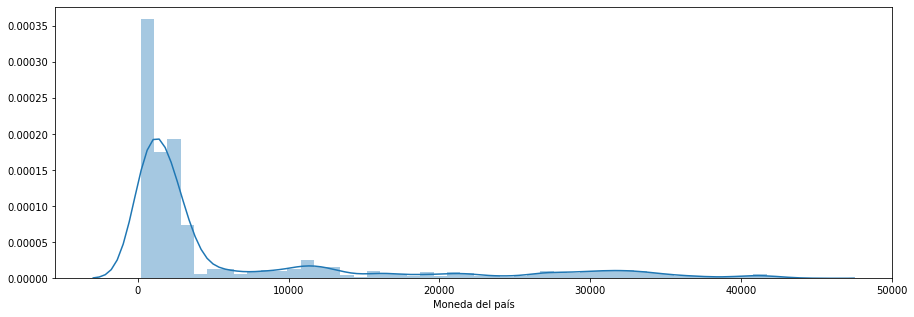

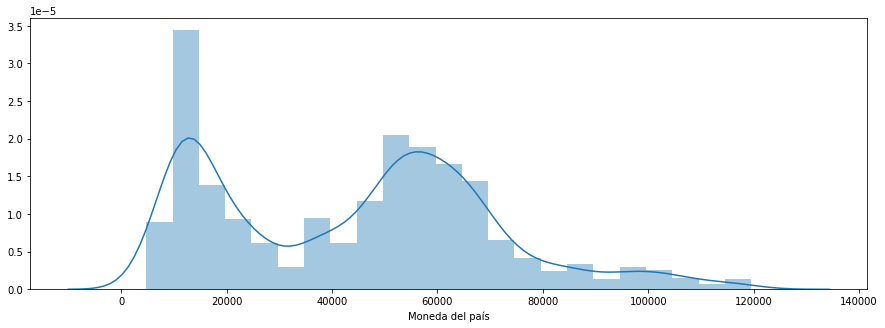

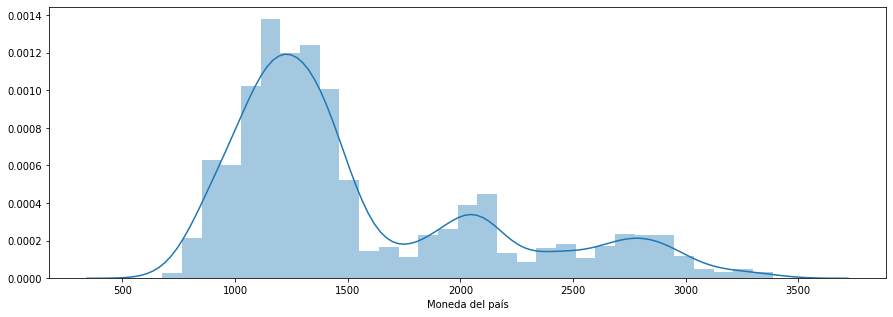

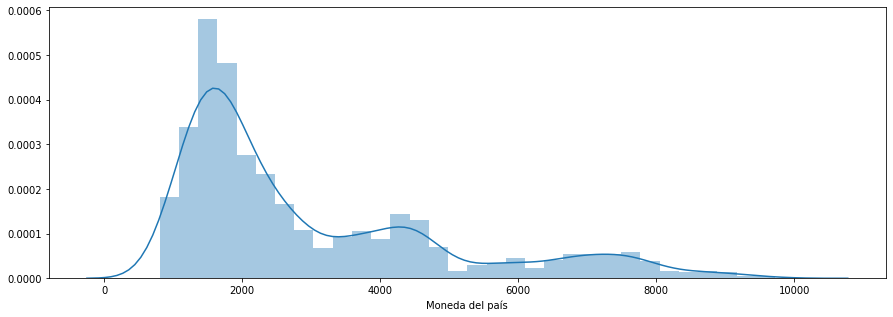

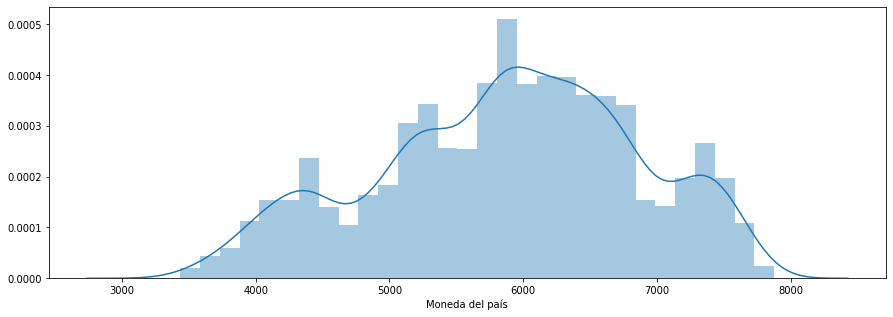

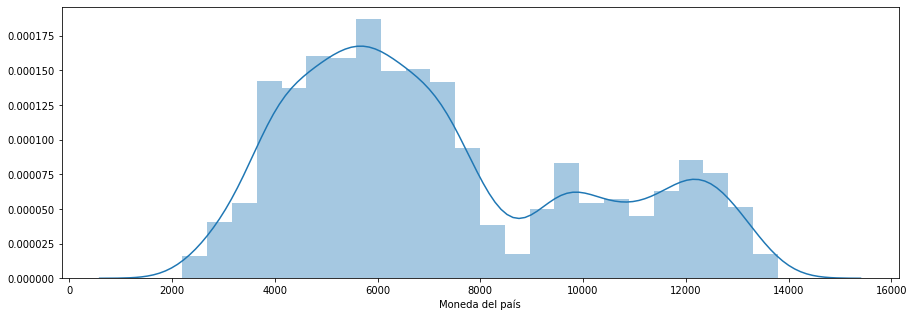

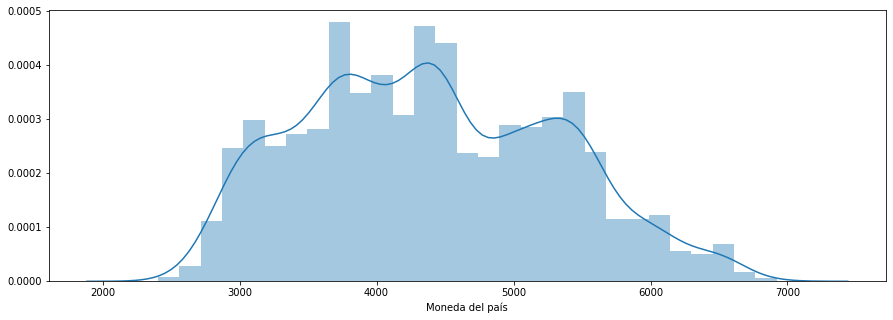

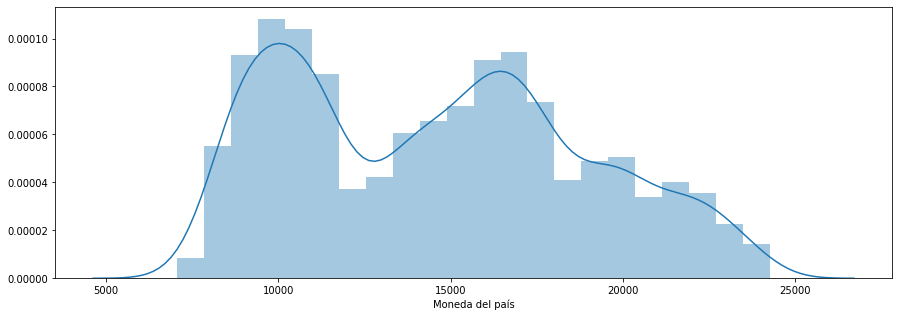

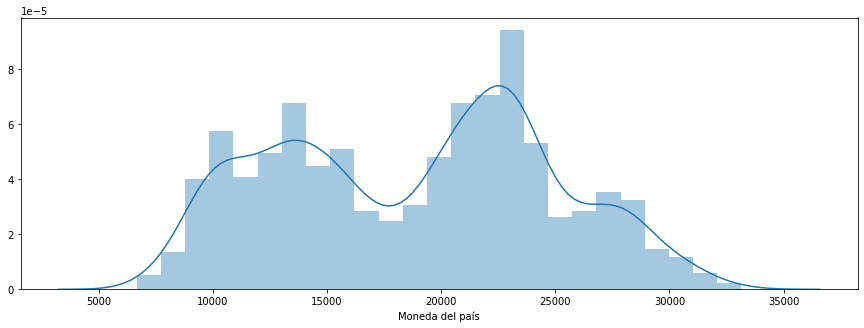

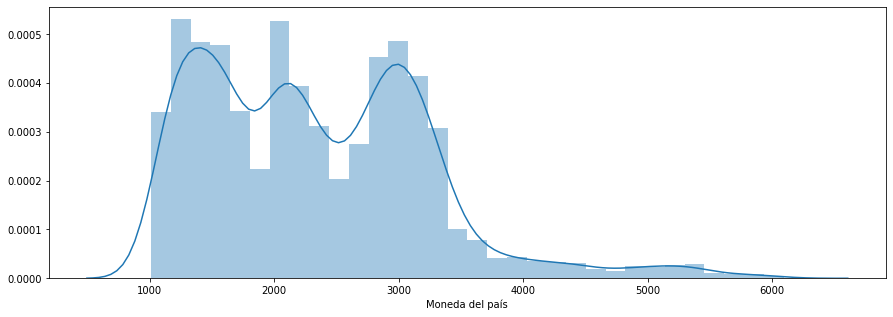

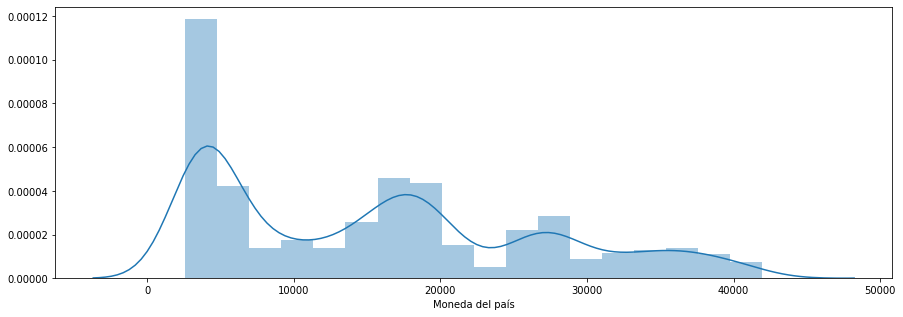

In [14]:
year_range = df.index.year.max() - df.index.year.min()

for col in df.columns:
    sns.distplot(df[col].dropna())
    plt.xlabel("Moneda del país")
    plt.show()

Por último, se crearon boxplots para cada una de las variables. Esto permitió analizar la distribución estadística de los datos y observar que la misma va modificandose año a año, confirmando así que las series temporales de los índices no son estacionarias. Además, los gráficos boxplot también fueron utilizados para encontrar outliers en la muestra. 

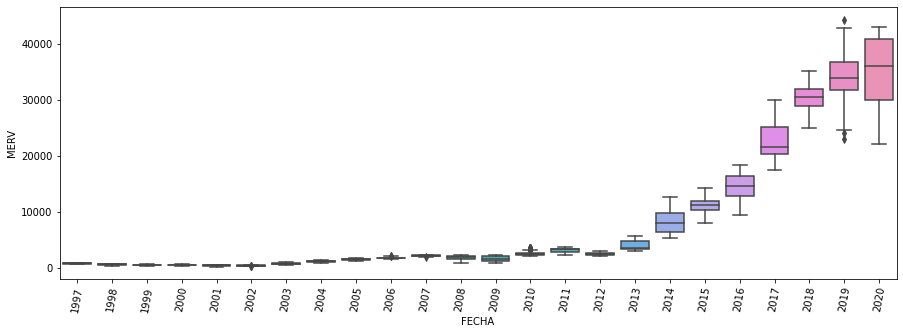

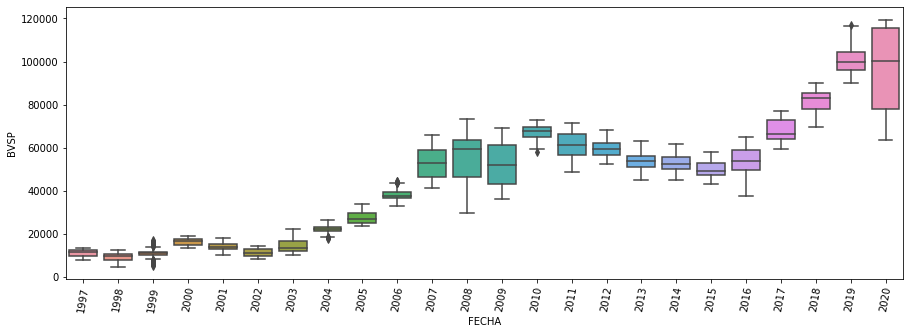

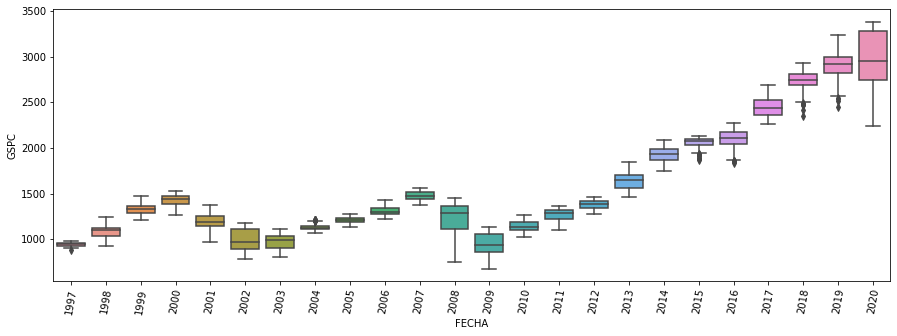

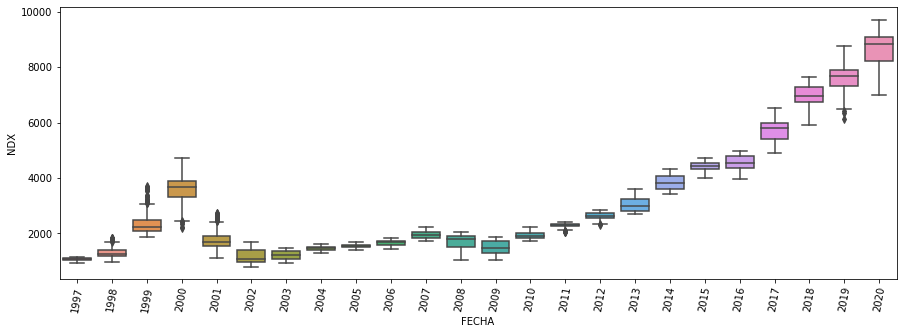

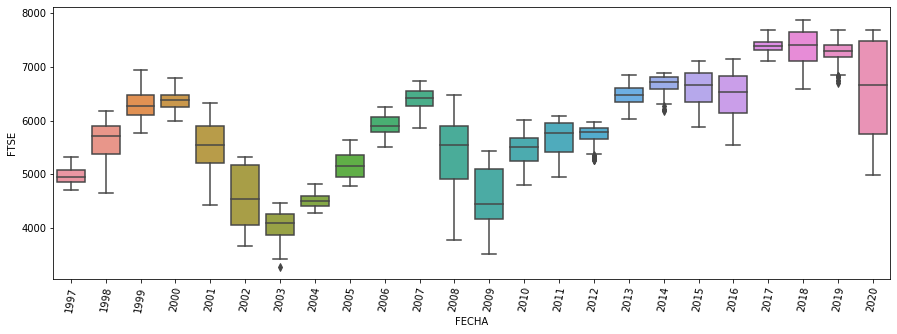

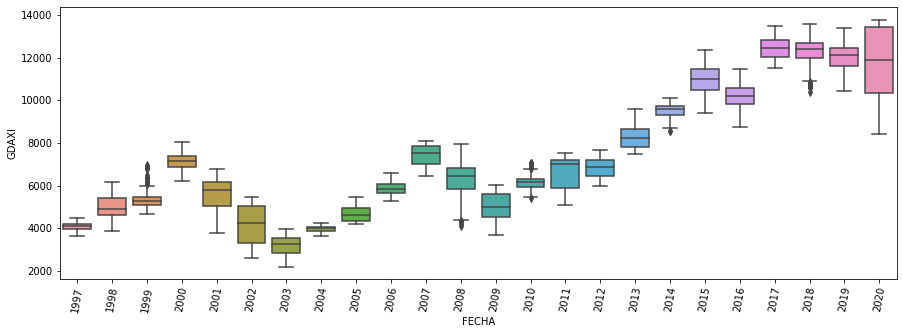

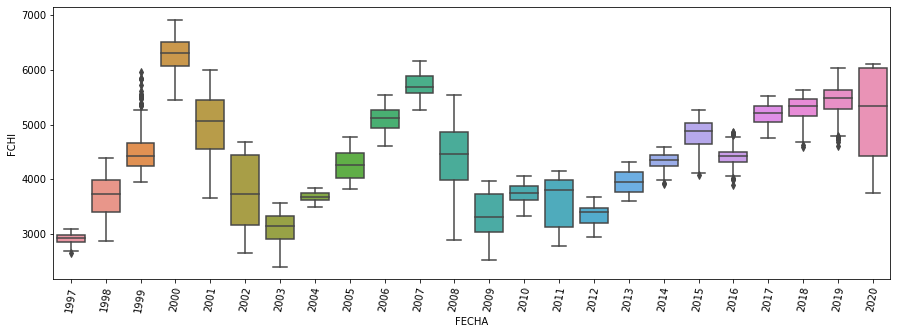

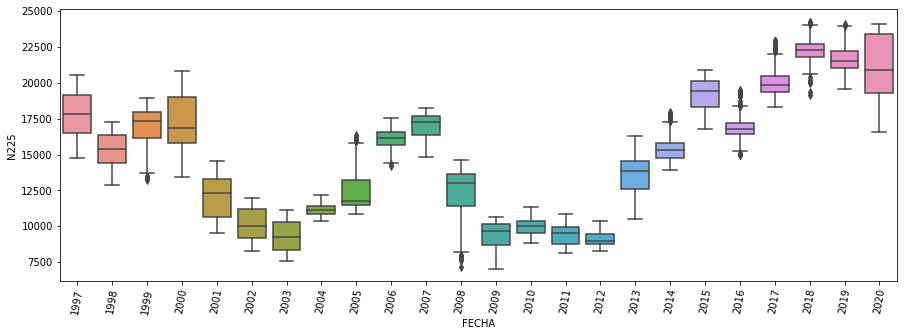

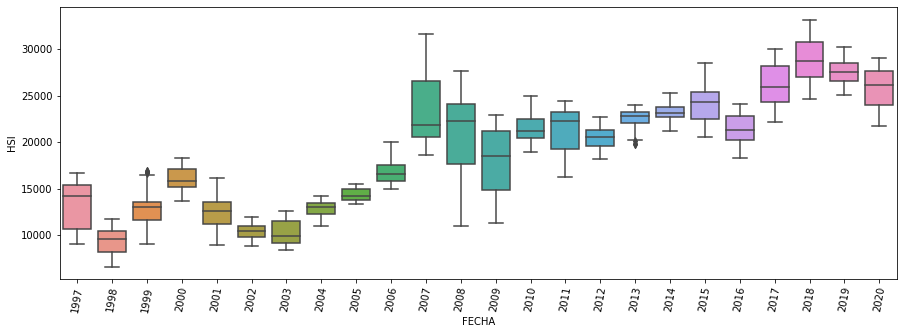

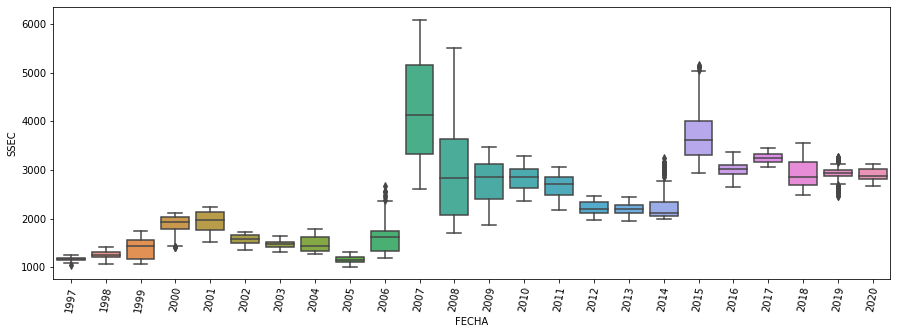

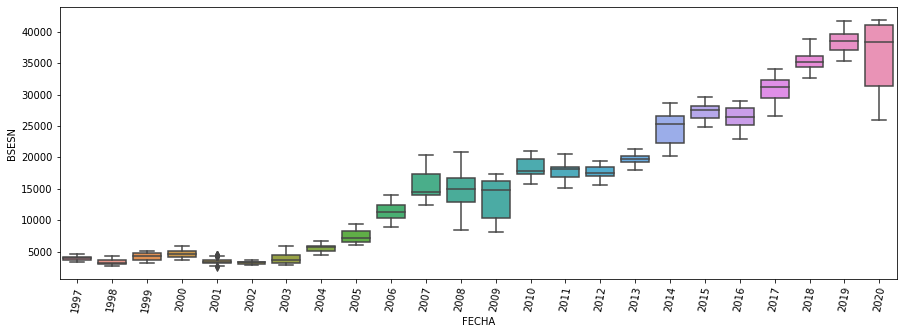

In [15]:
for col in df.columns:
    sns.boxplot(data=df, x=df.index.year, y=col)
    plt.xticks(rotation=80)
    plt.show()

#### Paso 4: Identificación de Outliers

Para identificar los outliers, se utilizaron dos métodos. Identificación a través de la base recalculada con la media móvil de cada variable, con una ventana de 5 observaciones (es decir, periodo semanal) e identificación con los valores originales de la base.

##### <ins>Utilización de media móvil<ins>:

In [16]:
#Para calcular la media móvil de cada variable, se eliminaron los datos correspondientes a los días Sabado y Domingo 
#que contenian valores nulos dado que no se miden estos índices los fines de semana. Además, los valores faltantes se completaron con el valor inmediato anterior.
#Esto debido a que si no no es posible calcular la media.

data_rm = df
data_rm = data_rm[data_rm.index.dayofweek<5]
data_rm = data_rm.fillna(method='ffill')

data_rm = data_rm.rolling(window=5).mean()
data_rm.columns = ['MERV_rm', 'BVSP_rm', 'GSPC_rm', 'NDX_rm', 'FTSE_rm', 'GDAXI_rm', 'FCHI_rm', 'N225_rm', 'HSI_rm', 'SSEC_rm', 'BSESN_rm']
data_rm.dropna()

MERV_rm  BVSP_rm      GSPC_rm       NDX_rm      FTSE_rm  \
FECHA                                                                      
1997-07-09    840.748010  13503.0   914.465991   995.997998  4795.220019   
1997-07-10    843.584009  13567.8   913.838000  1000.701990  4782.439941   
1997-07-11    846.118005  13499.6   913.790002  1006.521985  4779.779980   
1997-07-14    845.008008  13338.8   915.026001  1016.689990  4789.119922   
1997-07-15    837.323999  12938.8   916.428003  1027.331995  4817.279883   
...                  ...      ...          ...          ...          ...   
2020-05-04  32824.569920  80874.2  2877.755957  8842.631836  5898.379981   
2020-05-05  32920.905858  80506.0  2878.765967  8893.235938  5876.559961   
2020-05-06  33115.673828  79684.6  2860.547949  8893.656055  5824.259961   
2020-05-07  33737.148048  79207.2  2854.299951  8913.930078  5831.219922   
2020-05-08  34425.359768  79158.6  2874.117969  9014.364063  5865.799902   

                GDAXI_rm      FCHI_rm       N225_rm        HSI_rm   SSEC_rm  \
FECHA                                                                         
1997-07-09   3989.376025  2939.920020  19869.128126  14846.640042  1127.458   
1997-07-10   4001.560010  2938.340039  19795.801954  14803.340042  1121.364   
1997-07-11   4027.074024  2939.760059  19777.300000  14883.800004  1120.454   
1997-07-14   4054.841992  2938.540088  19882.010156  14986.260160  1138.234   
1997-07-15   4076.758008  2942.720069  19925.114062  15125.260160  1156.322   
...                  ...          ...           ...           ...       ...   
2020-05-04  10818.689844  4552.698047  19794.953514  24424.106248  2842.540   
2020-05-05  10805.455860  4535.366016  19764.585546  24282.646092  2852.552   
2020-05-06  10705.147854  4487.820020  19734.217578  24181.424218  2863.692   
2020-05-07  10684.673830  4473.671973  19630.433594  24048.832422  2865.980   
2020-05-08  10693.241994  4469.163965  19742.381640  23966.148438  2873.032   

                BSESN_rm  
FECHA                     
1997-07-09   4329.962012  
1997-07-10   4340.944043  
1997-07-11   4340.576074  
1997-07-14   4327.290039  
1997-07-15   4310.216016  
...                  ...  
2020-05-04  32797.054296  
2020-05-05  32664.852344  
2020-05-06  32457.970312  
2020-05-07  32003.122266  
2020-05-08  31588.137892  

[5958 rows x 11 columns]

In [17]:
def find_outliers(data, selected_index, year, number_of_stds):
    """Returns ouliers based on a number of standard deviations from the mean (number_of_stds) for a given column (selected_score)
    for a given year (year)
    """
    outliers = []
    # Filtro por año
    filtro = data[data.index.year.isin([year])]
    datos = filtro[selected_index]
    media = datos.mean()
    varianza = datos.std()
    #print("Media: ", media, "Varianza: ", varianza)
    for i in datos:
        if np.abs(i-media) > number_of_stds*varianza:
            outliers.append(i)    
    return outliers

for indice in data_rm.columns:
    print()
    for year in range(1970, 2020):
        num_outliers = len(find_outliers(data_rm,indice,year,2.5))
        if num_outliers > 0:
            print('Para el índice {}, en el año {} se encontraron {} valores outliers.'.format(indice, year, num_outliers))


Para el índice MERV_rm, en el año 2006 se encontraron 3 valores outliers.
Para el índice MERV_rm, en el año 2007 se encontraron 2 valores outliers.
Para el índice MERV_rm, en el año 2010 se encontraron 1 valores outliers.

Para el índice BVSP_rm, en el año 1999 se encontraron 7 valores outliers.
Para el índice BVSP_rm, en el año 2006 se encontraron 1 valores outliers.
Para el índice BVSP_rm, en el año 2010 se encontraron 3 valores outliers.
Para el índice BVSP_rm, en el año 2019 se encontraron 5 valores outliers.

Para el índice GSPC_rm, en el año 2000 se encontraron 2 valores outliers.
Para el índice GSPC_rm, en el año 2004 se encontraron 6 valores outliers.
Para el índice GSPC_rm, en el año 2012 se encontraron 1 valores outliers.
Para el índice GSPC_rm, en el año 2015 se encontraron 5 valores outliers.
Para el índice GSPC_rm, en el año 2018 se encontraron 7 valores outliers.
Para el índice GSPC_rm, en el año 2019 se encontraron 5 valores outliers.

Para el índice NDX_rm, en el año 1

##### <ins>Utilización de base original<ins>:

In [18]:
for indice in df.columns:
    print()
    for year in range(1970, 2020):
        num_outliers = len(find_outliers(df,indice,year,2.5))
        if num_outliers > 0:
            print('Para el índice {}, en el año {} se encontraron {} valores outliers.'.format(indice, year, num_outliers))


Para el índice MERV, en el año 2006 se encontraron 2 valores outliers.
Para el índice MERV, en el año 2007 se encontraron 1 valores outliers.
Para el índice MERV, en el año 2010 se encontraron 2 valores outliers.
Para el índice MERV, en el año 2019 se encontraron 1 valores outliers.

Para el índice BVSP, en el año 1999 se encontraron 7 valores outliers.
Para el índice BVSP, en el año 2004 se encontraron 1 valores outliers.
Para el índice BVSP, en el año 2006 se encontraron 2 valores outliers.
Para el índice BVSP, en el año 2010 se encontraron 2 valores outliers.
Para el índice BVSP, en el año 2019 se encontraron 4 valores outliers.

Para el índice GSPC, en el año 1997 se encontraron 1 valores outliers.
Para el índice GSPC, en el año 2000 se encontraron 2 valores outliers.
Para el índice GSPC, en el año 2001 se encontraron 1 valores outliers.
Para el índice GSPC, en el año 2004 se encontraron 5 valores outliers.
Para el índice GSPC, en el año 2011 se encontraron 1 valores outliers.
Par

#### Paso 5: Exploración existencia de Estacionalidad

Una serie se puede ver como un proceso estacionario si:
1. Su media es constante en el tiempo.
2. Su varianza es constante en el tiempo.
3. Su estructura de autocorrelación es constante en el tiempo.

Se graficaron la media de los valores de los índices y su desviación standar para una ventana de 60 días (aprox 2 meses) para ver el comportamiento de estas medidas a lo largo del tiempo. Se encontró que ni la media ni la desviación stardar son constantes en el tiempo, aunque se identificaron algunos momentos (cortos) de estacionalidad para algunos índices, como el Merval al comienzo del periodo de estudio:

Text(0.5, 1.0, 'Comportamiento de la varianza a lo largo del tiempo.\n')

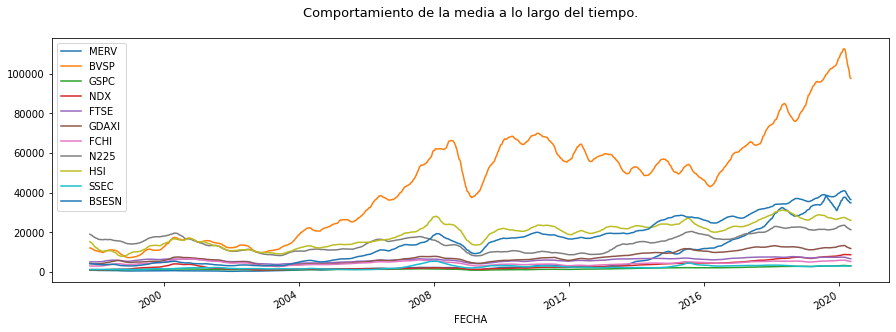

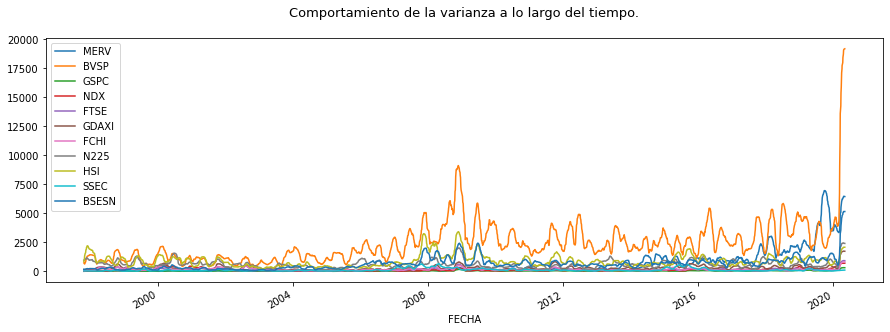

In [19]:
df.dropna().rolling(window=60).mean().plot()
plt.title("Comportamiento de la media a lo largo del tiempo.\n", fontdict={'fontsize': 13})
df.dropna().rolling(window=60).std().plot()
plt.title("Comportamiento de la varianza a lo largo del tiempo.\n", fontdict={'fontsize': 13})

#### Paso 6: Estudio de Evolución temporal de los índices

##### <ins>Evolución temporal de la serie sin normalizar<ins>:

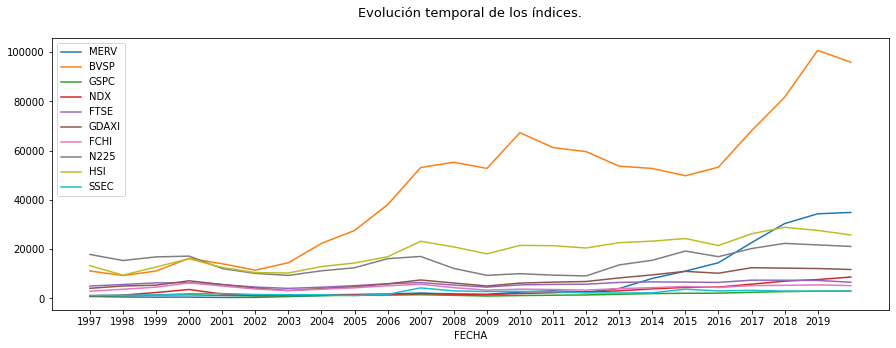

In [20]:
selected_indexes = ["MERV", "BVSP", "GSPC", "NDX", "FTSE", "GDAXI", "FCHI", "N225", "HSI", "SSEC"]
data = df[selected_indexes]
new_data = data.groupby(df.index.year).mean()
ax = sns.lineplot(data=new_data, hue= ["MERV", "BVSP", "GSPC", "NDX", "FTSE", "GDAXI", "FCHI", "N225", "HSI", "SSEC"], dashes=False)
ax.set_xticks(np.arange(data.index.year.min(), data.index.year.max(), step=1))
plt.title("Evolución temporal de los índices.\n", fontdict={'fontsize': 13})
plt.show()

##### <ins>Evolución temporal de la serie normalizada<ins>:

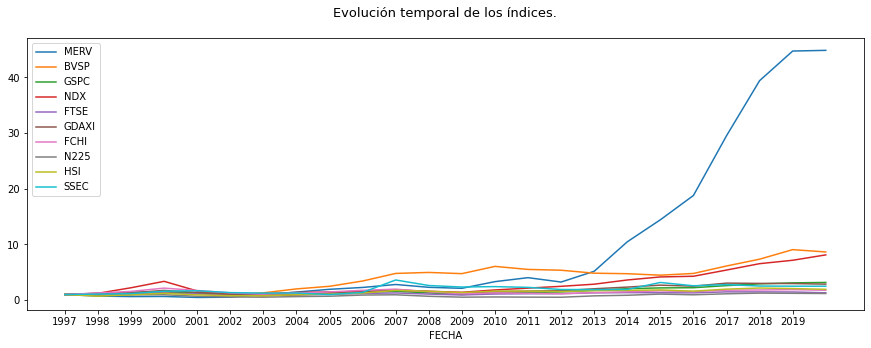

In [21]:
#PRUEBA
selected_indexes = ["MERV", "BVSP", "GSPC", "NDX", "FTSE", "GDAXI", "FCHI", "N225", "HSI", "SSEC"]
data_test = df[selected_indexes]

#Elimina fines de semana y rellena los valores nulos para poder calcular los números índices. El primer valor de la columna "HSI" es nulo y no permite construir el índice.
data_test = data_test[data_test.index.dayofweek<5]
data_test = data_test.fillna(method='ffill')
data_test['HSI'] = data_test.HSI.fillna(method='bfill')

data_test = data_test.groupby(data_test.index.year).mean()

normalize = data_test.iloc[0]

data_test = data_test/normalize

ax = sns.lineplot(data=data_test, hue= ["MERV", "BVSP", "GSPC", "NDX", "FTSE", "GDAXI", "FCHI", "N225", "HSI", "SSEC"], dashes=False)
ax.set_xticks(np.arange(data_test.index.min(), data_test.index.max(), step=1))
plt.title("Evolución temporal de los índices.\n", fontdict={'fontsize': 13})
plt.show()

#### Paso 7: Estudio de Correlación entre Índices, se mueven de manera conjunta?

Se encontró que para los años donde la correlación entre los índices es alto, los índices se mueven en forma conjunta. Cuando las curvas se separan (poca correlación), **significa crisis local** en el país cuyo índice estamos analizando, **o gran expansión** del mismo.

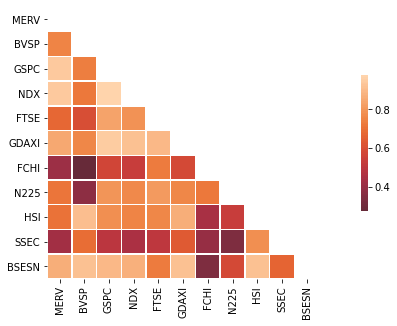

In [22]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

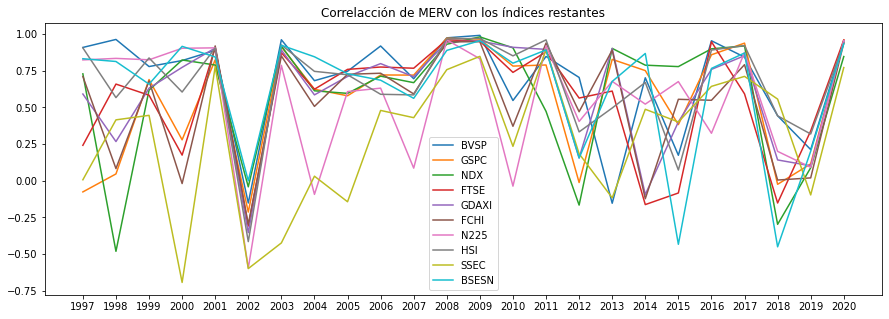

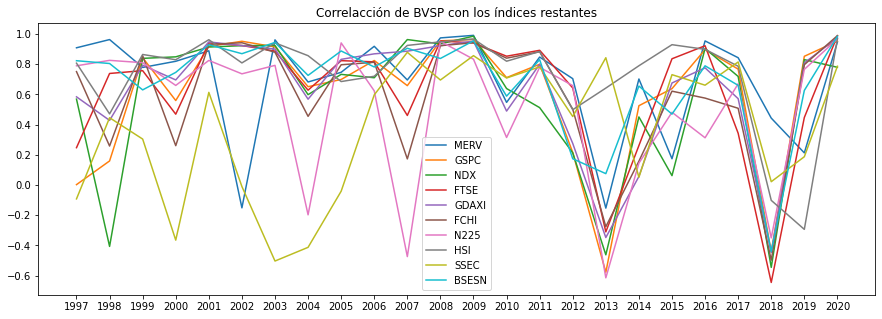

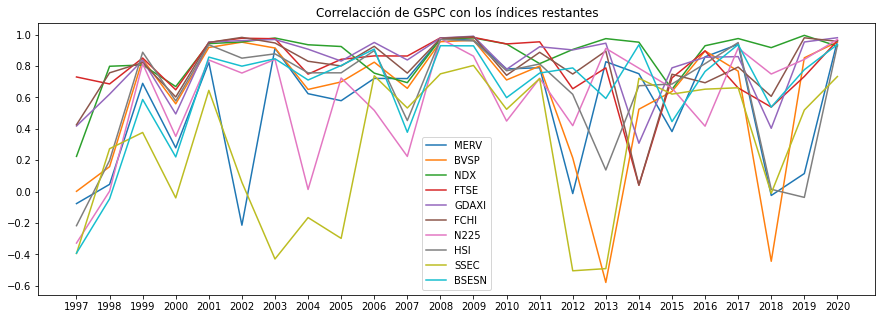

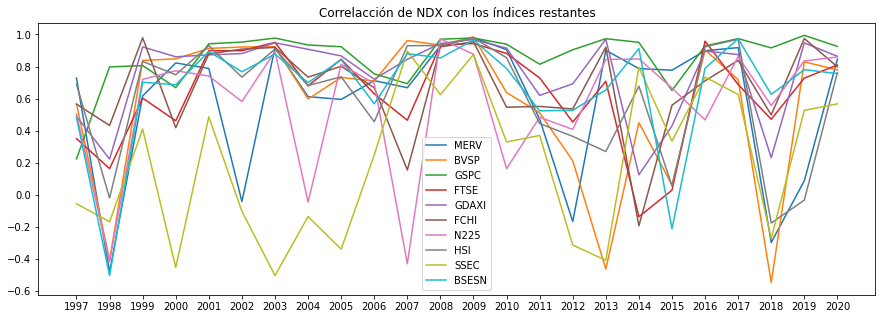

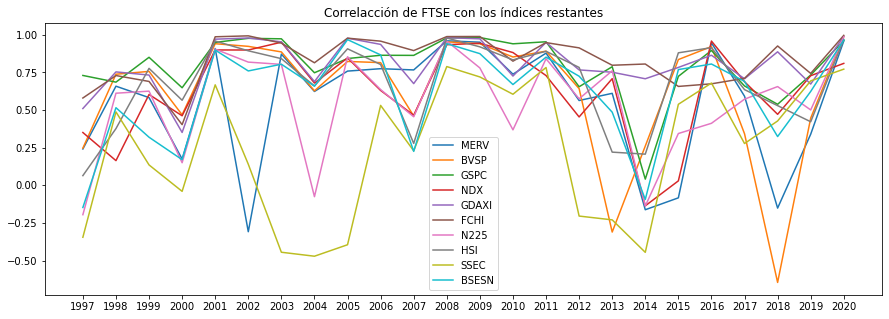

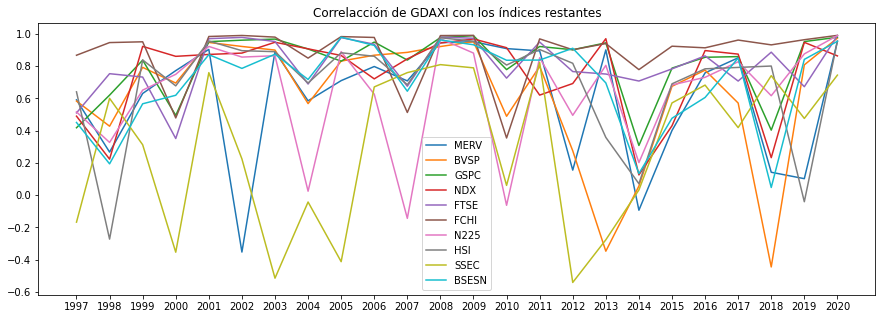

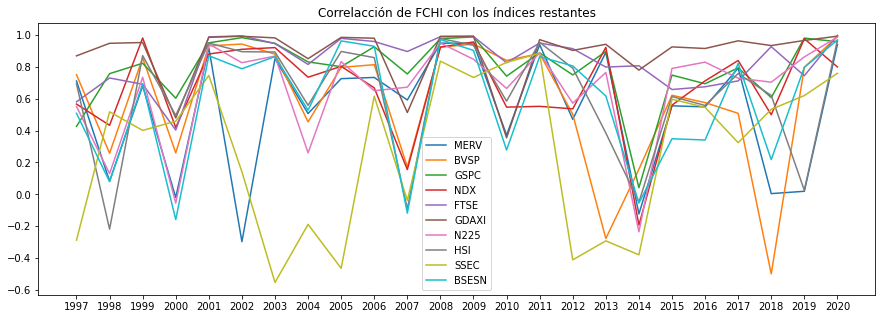

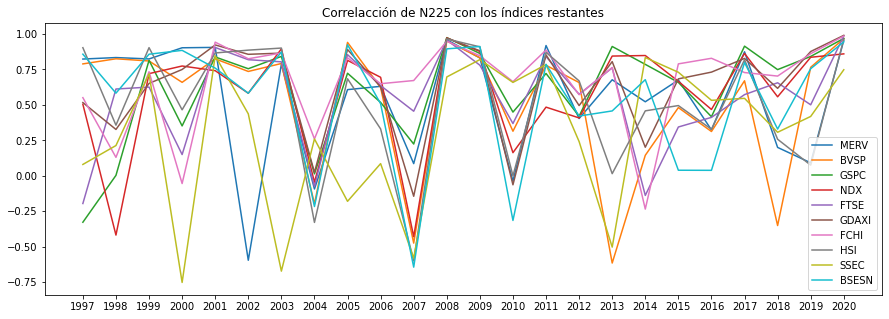

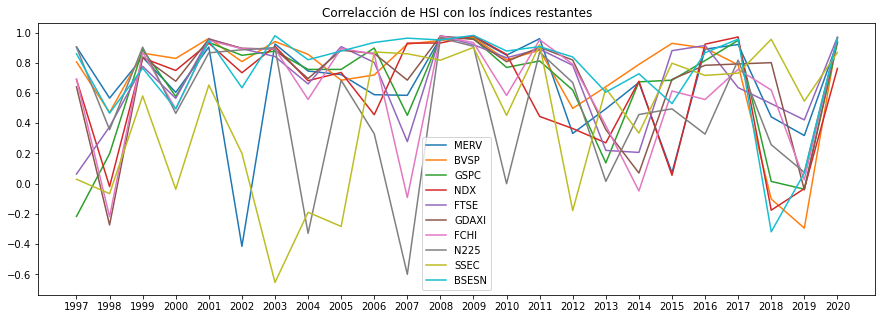

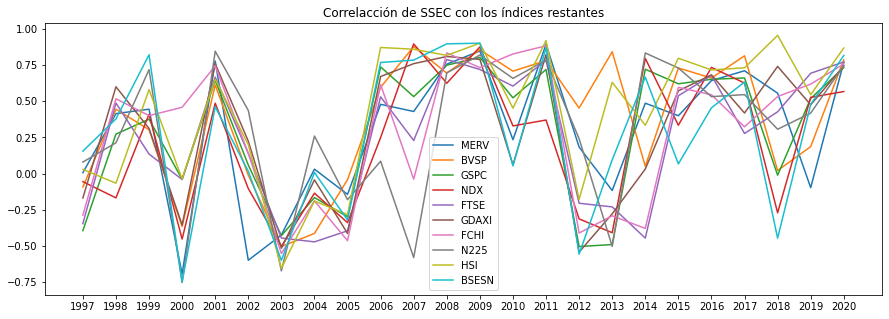

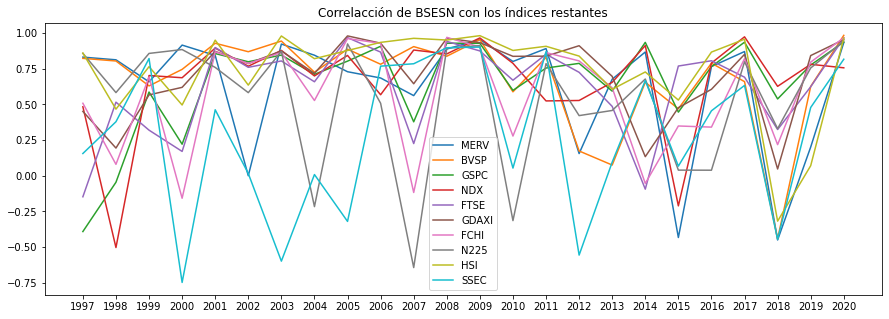

In [23]:
years = [year for year in df.index.year.unique()]
for index in df.columns:
    aux = pd.DataFrame()    
    for index_ in df.columns.drop(index):
        list_corr = []
        for year in df.index.year.unique():
            corr = df[[index, index_]][df[[index, index_]].index.year == year].corr().iloc[0,1]
            list_corr.append(corr)
            
        aux['{}'.format(index_)] = list_corr
    ax = aux.plot(xticks=range(24))
    ax.set_xticklabels(years)
    plt.title('Correlacción de {} con los índices restantes'.format(index))
    del aux

#### Paso 8: Selección de un índice y confección de diagrama de dispersión entre el mismo y su valor retardado 1,2,3 y 4 períodos

In [24]:
#Armo un df con el indice elegido y sus n retarnos
df_retardo = df[['MERV']].dropna()
for i in range(1,5):
    df_retardo['MERV_shift_{}'.format(i)] = df_retardo.MERV.shift(i)

Valores del índice contra su retardo en 1 periodos


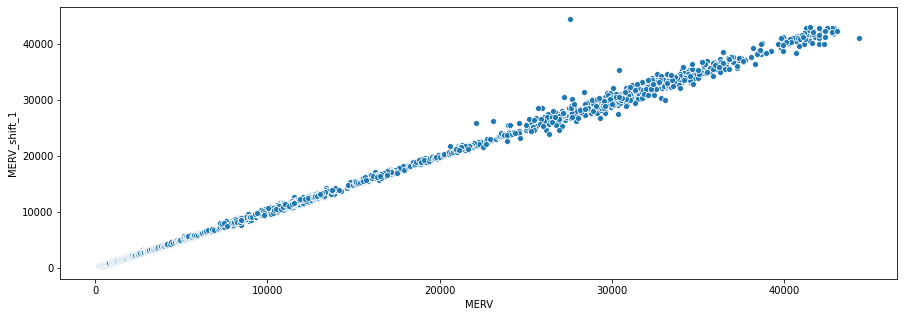


Valores del índice contra su retardo en 2 periodos


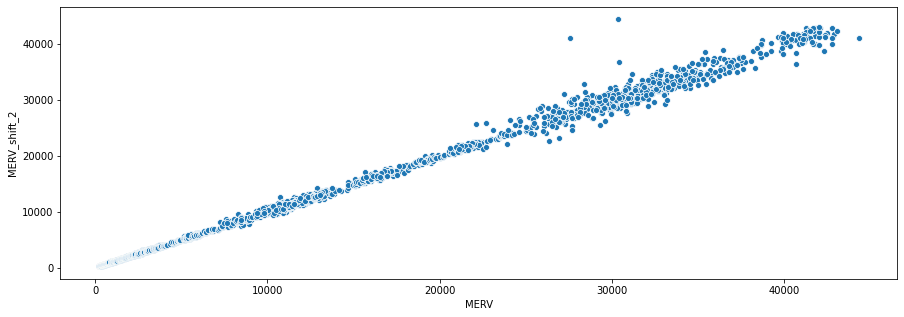


Valores del índice contra su retardo en 3 periodos


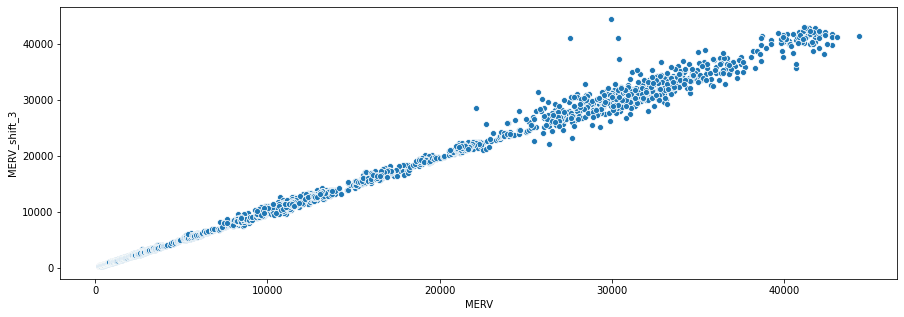


Valores del índice contra su retardo en 4 periodos


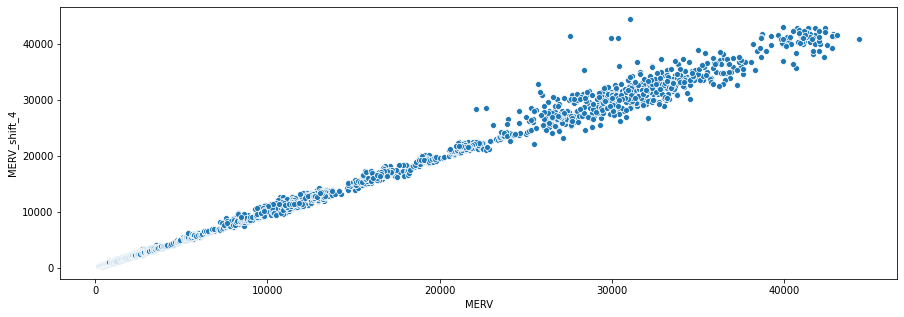

In [25]:
#Diagramas de dispersión
for i in range(1,5):
    print('Valores del índice contra su retardo en {} periodos'.format(i))
    ax = sns.scatterplot(x="MERV", y=df_retardo.columns[i], data=df_retardo)
    plt.show()
    print()

#### Paso 9: Interpretación de las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF)

Como se pudo observar en los correlogramas, en todos los casos **se registró una fuerte correlación** entre el valor de los índices y sus valores desplazados un lapso de tiempo $k$. Los intervalos de confianza, representados por la zona celeste, indican que aquellos valores de correlación que se encuentran fuera de esta zona son probablemente una correlación y no simple suerte o casualidad. Concluimos que en todos los casos, con un corrimiento de 200 observaciones, todos los índices tienen correlación, real, mayor a 0.5. Se puede observó que estas correlaciones, en algunos casos decaen suavemente, como por ejemplo para el índice MERV, mientras que en otros casos es más acentuada, como en el caso de SSEC. Para el índice FCHI, esta correlación decae hasta volverse negativa luego de 450 observaciones aproximadamente (450 días hábiles son aproximadamente 1 año y 11 meses).

De los gráficos correspondientes a la función de autocorrelación parcial, se pudo ver que hay una relación directa de los valores de los índices con aquellos separados por 1 retardo de tiempo, luego la relación parece ser despreciable. 


Función de autocorrelación y autocorrelación parcial para el índice MERV.


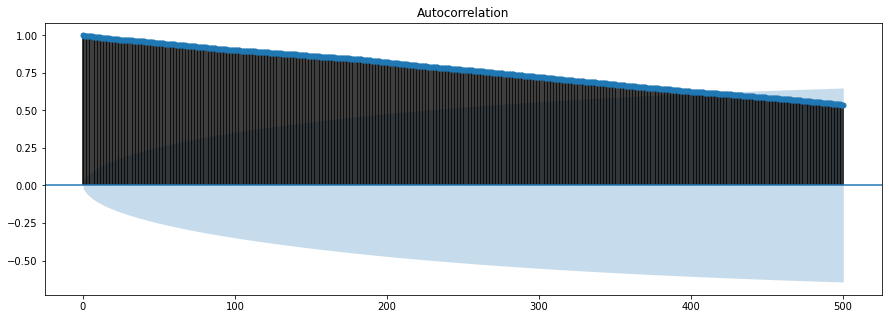

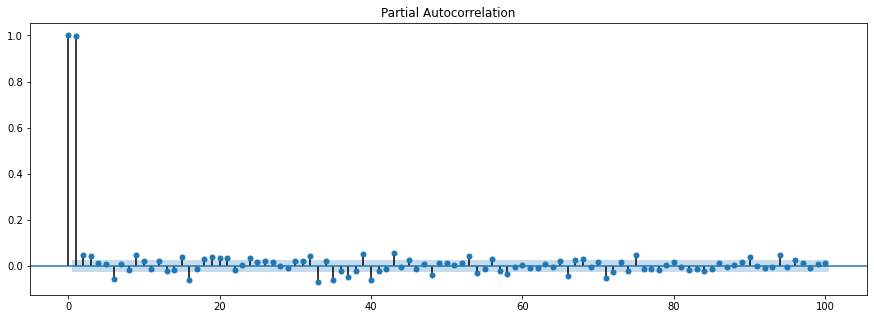

Función de autocorrelación y autocorrelación parcial para el índice BVSP.


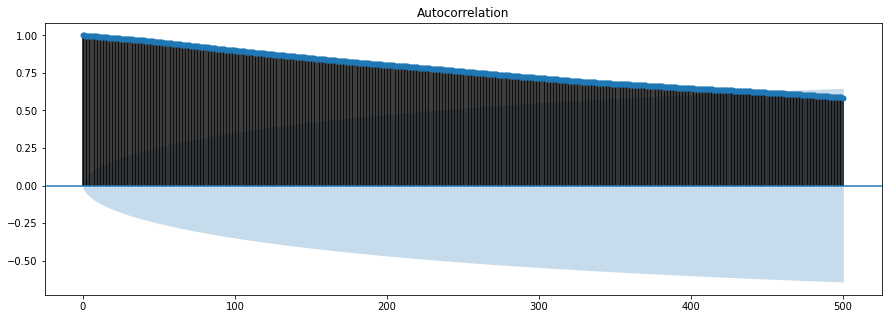

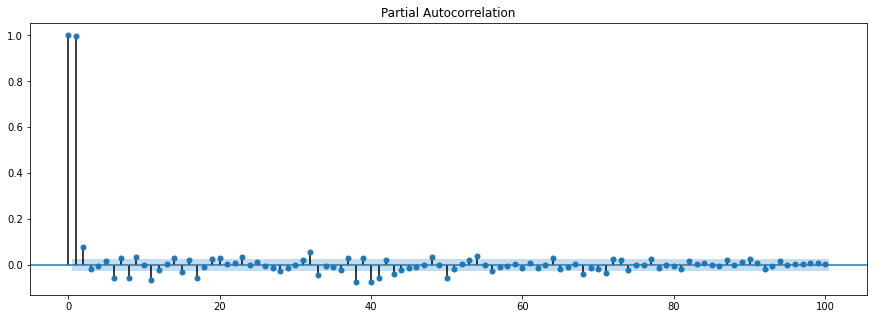

Función de autocorrelación y autocorrelación parcial para el índice GSPC.


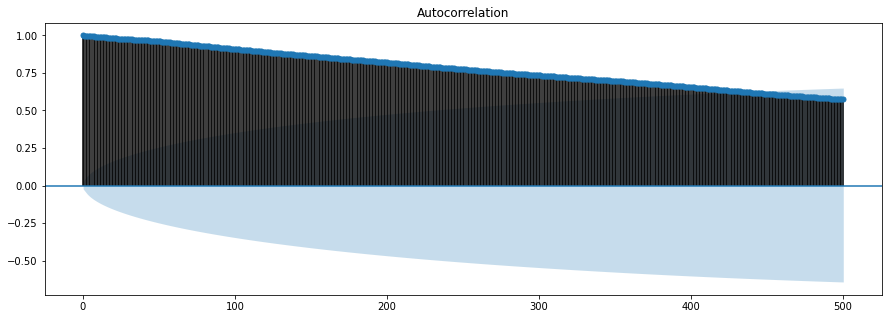

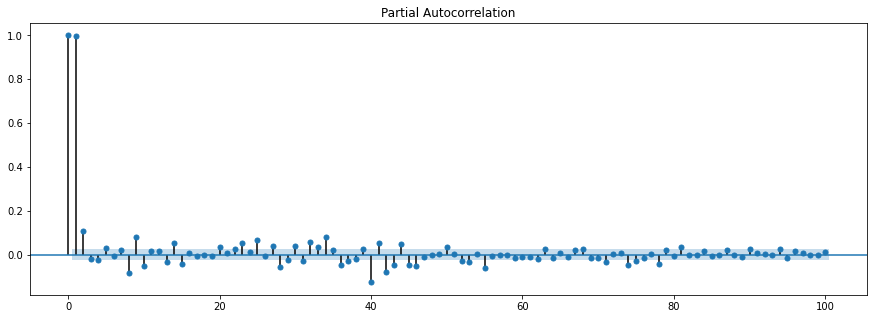

Función de autocorrelación y autocorrelación parcial para el índice NDX.


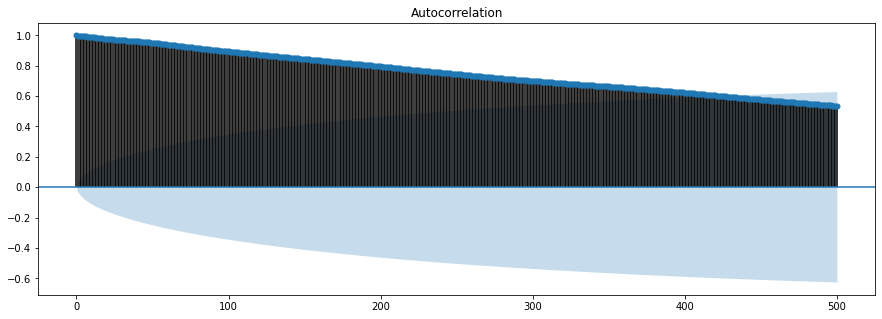

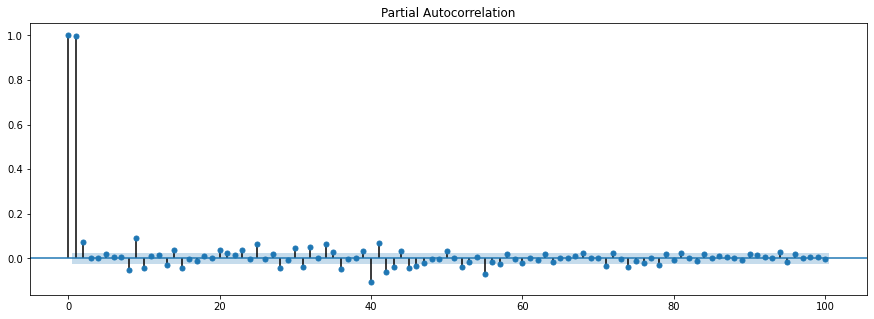

Función de autocorrelación y autocorrelación parcial para el índice FTSE.


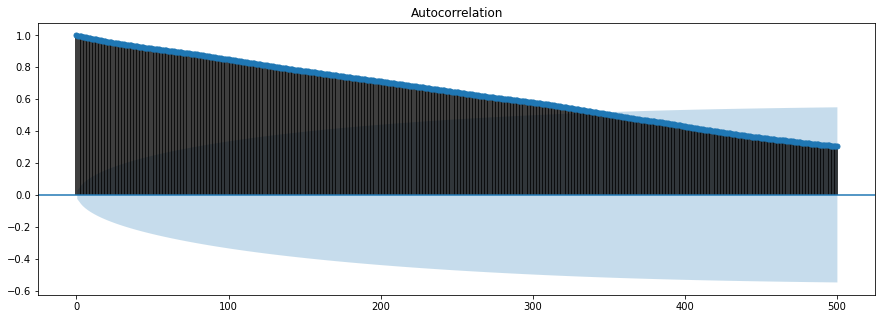

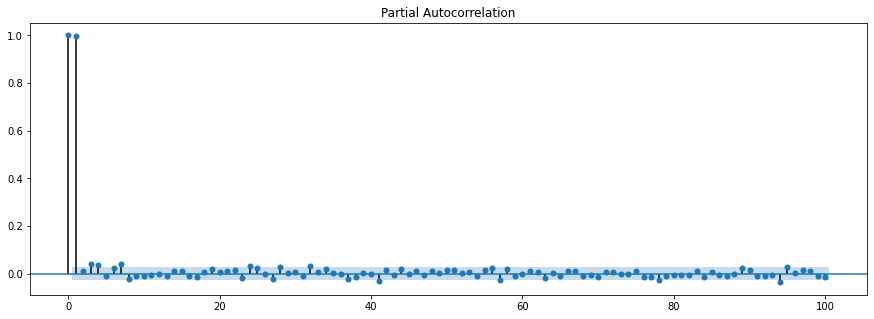

Función de autocorrelación y autocorrelación parcial para el índice GDAXI.


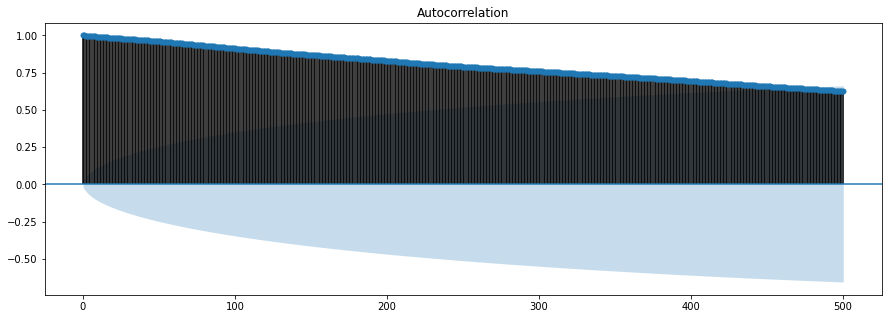

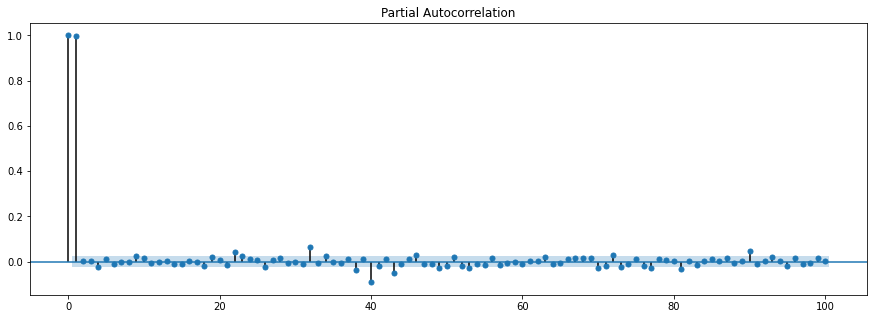

Función de autocorrelación y autocorrelación parcial para el índice FCHI.


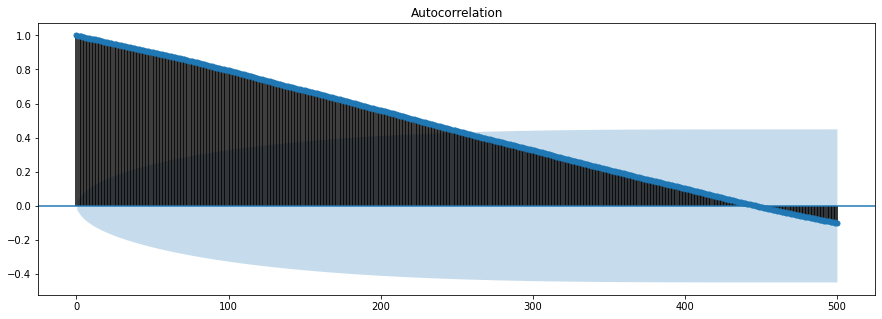

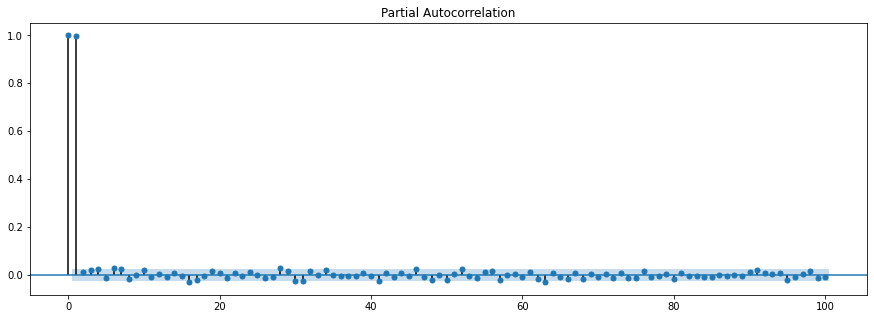

Función de autocorrelación y autocorrelación parcial para el índice N225.


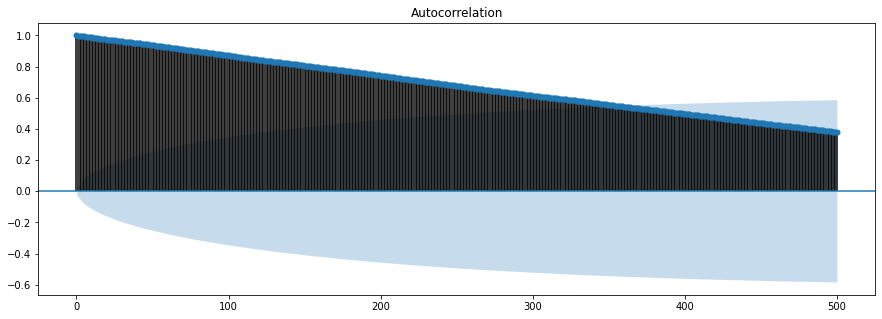

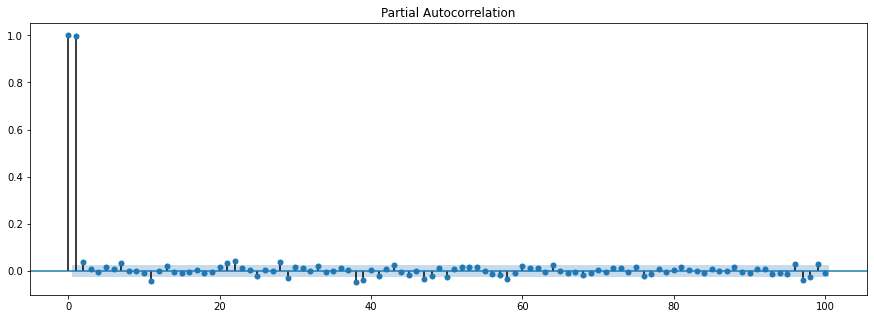

Función de autocorrelación y autocorrelación parcial para el índice HSI.


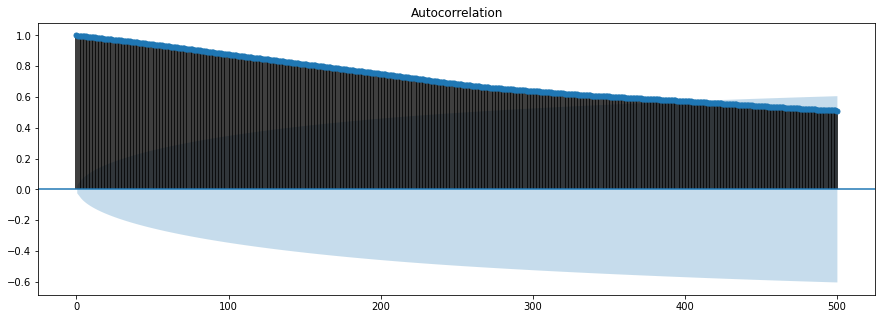

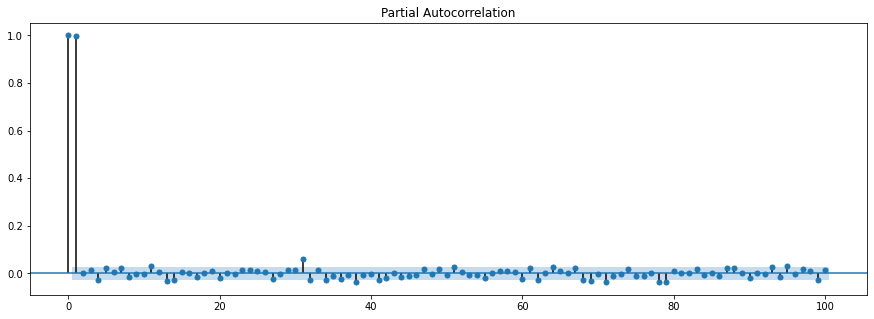

Función de autocorrelación y autocorrelación parcial para el índice SSEC.


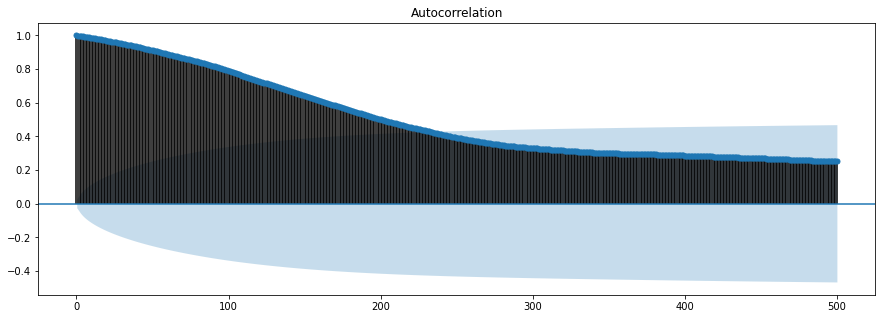

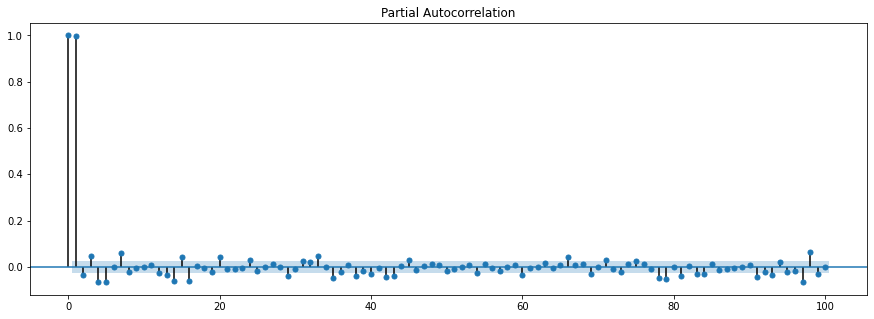

Función de autocorrelación y autocorrelación parcial para el índice BSESN.


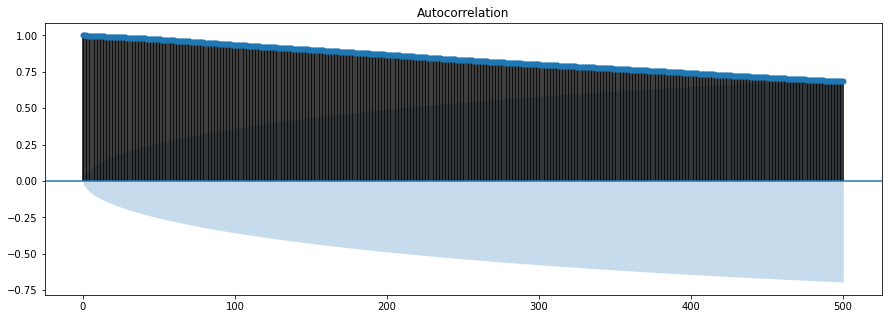

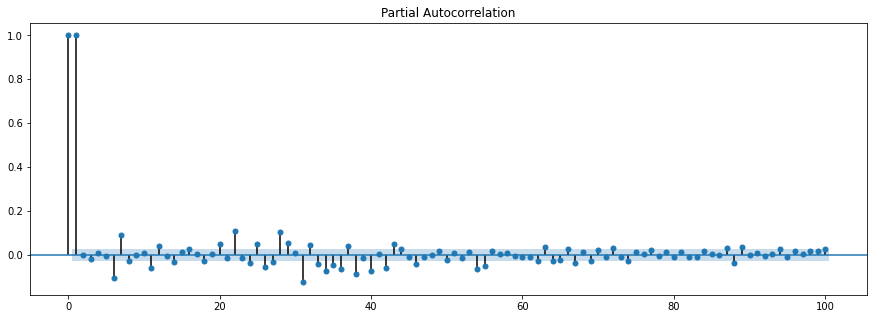

In [26]:
for indice in df.columns:
    print('Función de autocorrelación y autocorrelación parcial para el índice {}.'.format(indice))
    series = df[indice].dropna()
    plot_acf(series, lags = 500)
    plt.show()
    plot_pacf(series, lags=100)
    plt.show()

## <ins>Práctico N°2: Análisis Exploratorio y Curación de Datos<ins>

En este práctico se continuó con la exploración del dataset iniciada en el TP1. De lo desarrollado en el primer práctico se pudo notar algunas características propias de los datos de series temporales y en particular de los índices financieros. Algunas de ellas son que se trata de __series no estacionarias__, o sea que sus distribuciones cambian a través del tiempo y además sus trayectorias no son determinísticas sino que se trata de procesos con __raices unitarias__. __Tampoco se apreciaron patrones de estacionalidad__. Lo antes descripto tuvo __consecuencias__ directas en la selección de las metodologías adecuadas para abordar las problemáticas de tratamiento de __valores faltantes__, detección de __outliers__ y la construcción de __modelos predictivos y/o causales__.

Por otra parte, debe notarse que los índices son escencialmente promedios ponderados de los precios de los activos que los componen y a su vez que el precio de una acción sea mayor al de otra no significa directamente un mayor valor de la firma, dado que la cantidad de acciones emitidas por cada empresa no es la misma. Entonces, el análisis de este tipo de series se centra por lo general en el cambio porcentual de los precios en vez del cambio en los valores absolutos. 

En este práctico se realizó __transformación logarítmica__ de los índices utilizados asi como también el cálculo de la __tasa de rendimiento__. Además, los índices se encontraban expresados en distintas monedas, por lo que a la hora de comparar sus evoluciones o tasas de rendimiento se los reexpresó en un __único signo monetario__ para evitar distorsiones debidas a los procesos inflacionarios, especialmente en el caso de las economías emergentes.

#### Paso 1: Tratamiento de Datos Faltantes

Se identificaron dos clases de datos faltantes. Por un lado, los correspondientes a los fines de semana donde la ausencia de información se debe a la naturaleza de los datos (los mercados financieros sólo cotizan los días hábiles). Por otro lado, se identificaron datos faltantes correspondientes a feriados, aquí para una determinada fecha se identificaron series con datos ausentes mientras las restantes tenían información.

Se tomó la decisión de eliminar las observaciones correspondientes a los fines de semana y se imputaron los datos faltantes correspondientes a feriados utilizando un algortimo adecuado para series temporales.

##### <ins>Eliminación de observaciones correspondientes a fines de semana<ins>:

In [27]:
df = df_[df_.index.dayofweek < 5]

##### <ins>Elección del mejor método de interpolación de datos<ins>:

Se imputaron los datos faltantes usando interpolanción lineal  e interpolación cúbica, la cual resultó ser más suave. Se comparó ambos métodos con un índice en particular (MERV) y luego se generalizó el procedimiento para toda la serie:

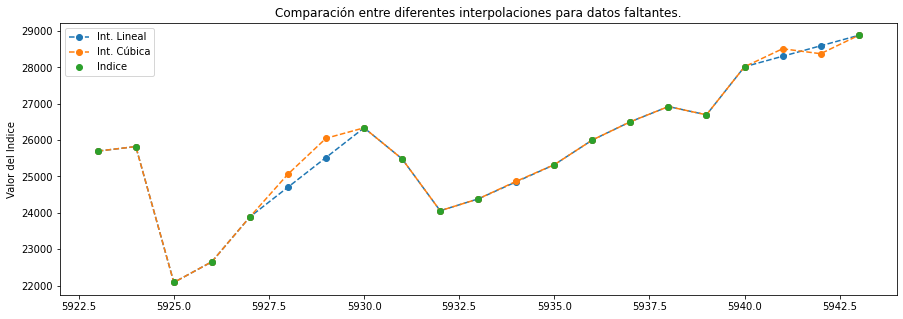

In [28]:
df_merv = df[['MERV']]
df_merv['new_index'] = np.array(range(len(df_merv)))

df_merv_dropna=df_merv.dropna()

y = np.array(df_merv.MERV)
x = np.array(df_merv.new_index)

y_dropna = np.array(df_merv_dropna.MERV)
x_dropna = np.array(df_merv_dropna.new_index)

f_lineal = interp1d(x_dropna, y_dropna)
f_cubic = interp1d(x_dropna, y_dropna, kind='cubic')

y_lineal = f_lineal(x)
y_cubic = f_cubic(x)

x, y, y_lineal, y_cubic = x[-40:-19],y[-40:-19],y_lineal[-40:-19],y_cubic[-40:-19]

plt.plot(x,y_lineal, marker='o', ls = '--')
plt.plot(x,y_cubic, marker='o', ls = '--')
plt.plot(x,y, 'o')

plt.legend(['Int. Lineal', 'Int. Cúbica','Indice'], loc='best')
plt.title('Comparación entre diferentes interpolaciones para datos faltantes.')
plt.ylabel('Valor del Indice')
plt.show()

Del ejemplo anterior se pudo concluir que es más conveniente utilizar interpolación cúbica en lugar de lineal por lo que se generalizó este tratamiento en todas las columnas del dataframe. Se utilizó la opción de extrapolar los datos lo cual permitió darle valores a las series que comenzaban o terminaban con NaN: 

In [29]:
df_interpolate = df.copy()

for col in df.columns:
    
    df_temp = df[[col]]
    df_temp['new_index'] = np.array(range(len(df_temp)))
    
    df_temp_dropna=df_temp.dropna()

    y = np.array(df_temp[col])
    x = np.array(df_temp.new_index)

    y_dropna = np.array(df_temp_dropna[col])
    x_dropna = np.array(df_temp_dropna.new_index)
    
    f_lineal = interp1d(x_dropna, y_dropna, fill_value="extrapolate")
    f_cubic = interp1d(x_dropna, y_dropna, kind='cubic', fill_value="extrapolate")

    y_lineal = f_lineal(x)
    y_cubic = f_cubic(x)
    
    df_interpolate[col] = y_cubic
    del df_temp, df_temp_dropna, x, y, x_dropna, y_dropna, f_lineal, f_cubic, y_lineal, y_cubic
    
df = df_interpolate.copy()

#### Paso 2: Expresión en Moneda Común

Como primera medida, se construyó una serie corregida para el tipo de cambio de Argentina. Para ello se sobreescribieron las cotizaciones oficiales con los valores del _DOLAR_BLUE_ en los períodos de cepo cambiario, o sea 28/10/2011 - 16/12/2015 y  01/09/2019 - 08/05/2020.

In [30]:
cepo_1 = (df.index >= '2011-10-28') & (df.index <= '2015-12-16')
cepo_2 = (df.index >= '2019-09-01') & (df.index <= '2020-05-08')
cepo = (cepo_1 | cepo_2)
df['DEXARUS'][cepo] = df['DOLAR_BLUE']

Luego, se expresaron todos los índices en dólares estadounidenses:

Text(0.5, 1.0, 'Evolución de los índices a través del tiempo.')

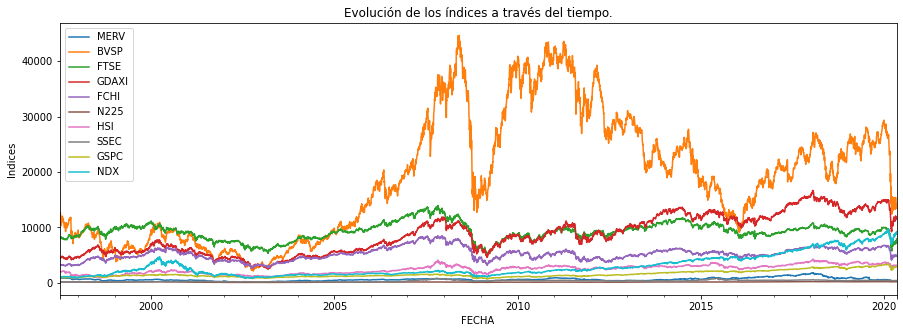

In [31]:
df_us = pd.DataFrame(index=df.index)
df_us['MERV'] = df['MERV'] / df['DEXARUS'] # Divido porque el par esta en X/US
df_us['BVSP'] = df['BVSP'] / df['DEXBZUS']
df_us['FTSE'] = df['FTSE'] * df['DEXUSUK'] # Multiplico porque el par esta en US/X
df_us['GDAXI'] = df['GDAXI'] * df['DEXUSEU']
df_us['FCHI'] = df['FCHI'] * df['DEXUSEU']
df_us['N225'] = df['N225'] / df['DEXJPUS']
df_us['HSI'] = df['HSI'] / df['DEXHKUS']
df_us['SSEC'] = df['SSEC'] / df['DEXCHUS']
#df_us['BSESNUS'] = df['BSESN'] / df['DEX?']

#A continuación agregamos los índices GSPC y NDX.
df_us['GSPC'] = df['GSPC']
df_us['NDX'] = df['NDX']

df_us.plot();
plt.ylabel('Indices')
plt.title('Evolución de los índices a través del tiempo.')

#### Paso 3: Transformación de las series en logaritmos y tasas de rendimiento

##### <ins>Transformación de las series en logaritmos<ins>:

Text(0.5, 1.0, 'Evolución de los índices a través del tiempo.')

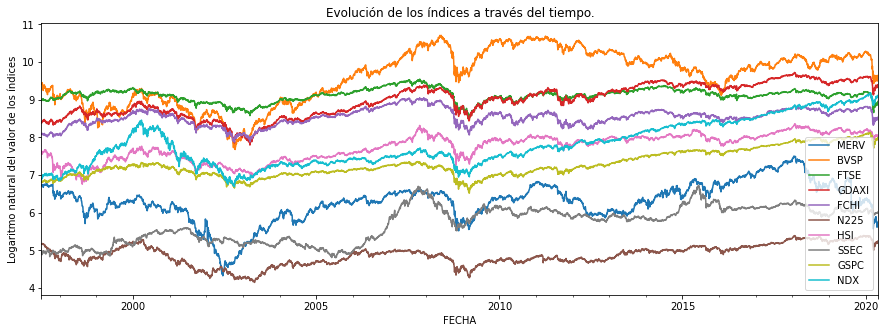

In [32]:
series_log = np.log(df_us)

series_log.plot();
plt.ylabel('Logaritmo natural del valor de los índices')
plt.title('Evolución de los índices a través del tiempo.')

##### <ins>Transformación de las series en tasas de rendimiento<ins>:

Text(0.5, 1.0, 'Evolución de los índices a través del tiempo.')

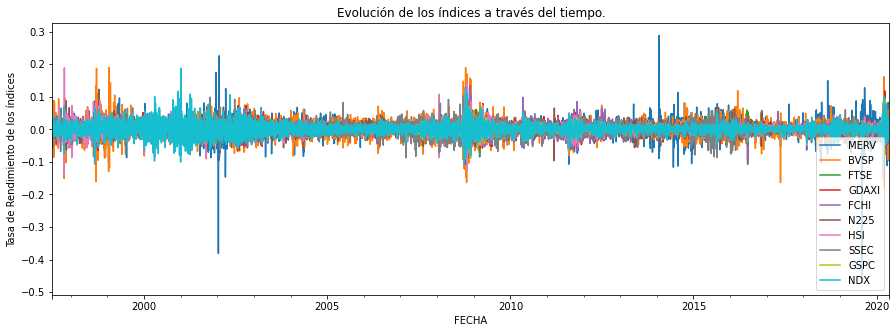

In [33]:
tasa_rend = df_us.pct_change().replace(np.nan,0)

tasa_rend.plot();
plt.ylabel('Tasa de Rendimiento de los índices')
plt.title('Evolución de los índices a través del tiempo.')

#### Paso 4: Análisis Exploratorio de las Series Transformadas

Este análisis es similar al realizado anteriormente sobre la base de datos sin transformar. Es por ello que en este caso se eligió trabajar sobre sólo una de las series. En particular, se escogió el índice MERV:

##### <ins>Análisis de las series en logaritmos<ins>:


 MERV 

MEDIA:  6.29
VARIANZA:  0.27
COEF. DE VARIACION:  0.083 => 8.3 %
INDICE DE SIMETRÍA DE PEARSON: -0.18
COEF. DE CURTOSIS: 1.49


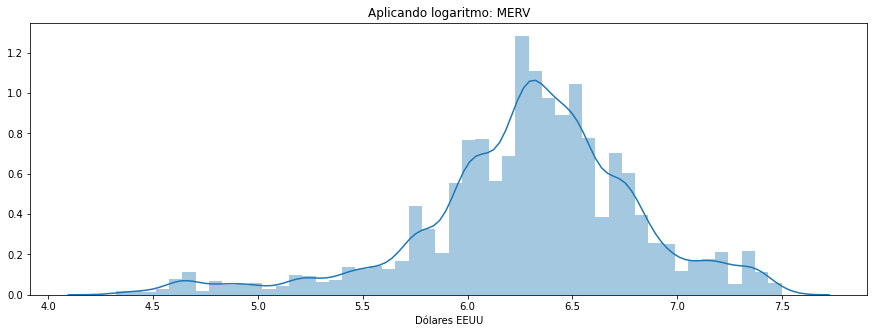

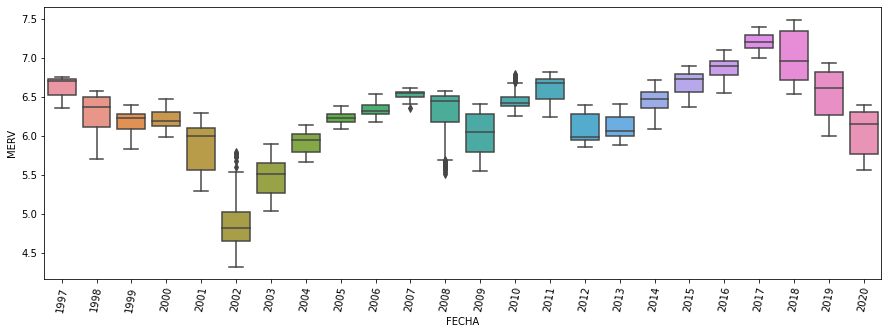

In [34]:
selected_cols = ["MERV"] #Elijo para comparar Arg vs UK

# Estadistica descriptiva
for col in selected_cols:
    print('\n',col,'\n')
    mean = series_log[col].mean()
    median = series_log[col].median()
    var = series_log[col].var()
    std = series_log[col].std()
    coef = std/mean
    indice_simetria_pearson = 3*(mean - median)/std
    coef_curtosis = series_log[col].kurt()
    
    print('MEDIA: ', round(mean,2))
    print('VARIANZA: ', round(var,2))
    print('COEF. DE VARIACION: ', round(coef,4), '=>', round(coef * 100,2), '%')
    print('INDICE DE SIMETRÍA DE PEARSON:', round(indice_simetria_pearson,2))
    print('COEF. DE CURTOSIS:', round(coef_curtosis,2))
    
# Analisis de las distribuciones
year_range = df.index.year.max() - df.index.year.min()
for col in selected_cols:
    sns.distplot(series_log[col].dropna())
    plt.xlabel("Dólares EEUU")
    plt.title("Aplicando logaritmo: "+col)
    plt.show()

# Analisis de las distribuciones por año
for col in selected_cols:
    sns.boxplot(data=series_log, x=df.index.year, y=col)
    plt.xticks(rotation=80)
    plt.show()

##### <ins>Análisis de las series transformadas a tasas de rendimiento<ins>:


 MERV 

MEDIA:  0.00017
VARIANZA:  0.00062
COEF. DE VARIACION:  149.1572 => 14915.72 %
INDICE DE SIMETRÍA DE PEARSON: -0.06
COEF. DE CURTOSIS: 37.62


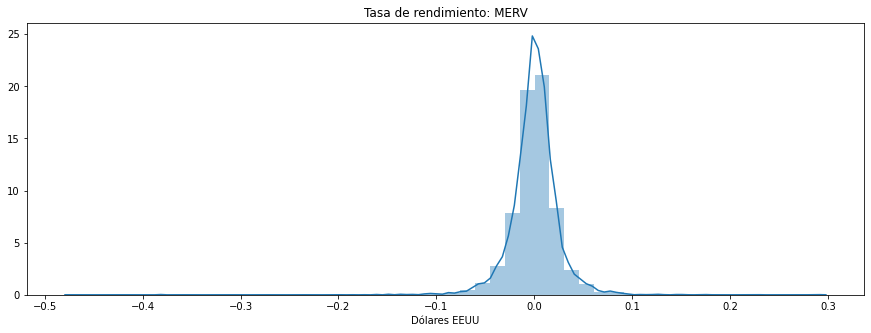

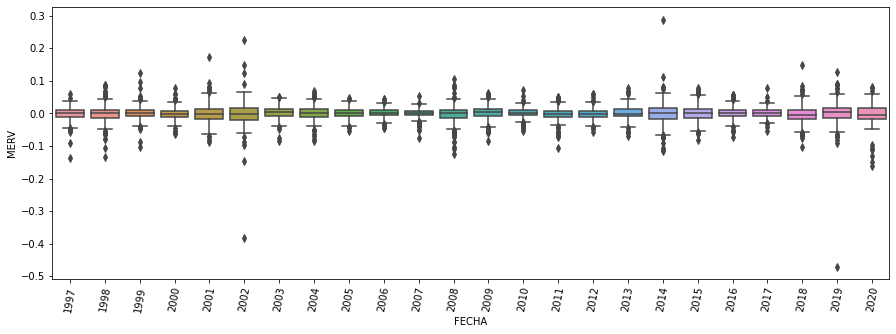

In [35]:
# Estadistica descriptiva
for col in selected_cols:
    print('\n',col,'\n')
    mean = tasa_rend[col].mean()
    median = tasa_rend[col].median()
    var = tasa_rend[col].var()
    std = tasa_rend[col].std()
    coef = std/mean
    indice_simetria_pearson = 3*(mean - median)/std
    coef_curtosis = tasa_rend[col].kurt()
    
    print('MEDIA: ', round(mean,5))
    print('VARIANZA: ', round(var,5))
    print('COEF. DE VARIACION: ', round(coef,4), '=>', round(coef * 100,2), '%')
    print('INDICE DE SIMETRÍA DE PEARSON:', round(indice_simetria_pearson,2))
    print('COEF. DE CURTOSIS:', round(coef_curtosis,2))
    
# Analisis de las distribuciones
year_range = df.index.year.max() - df.index.year.min()
for col in selected_cols:
    sns.distplot(tasa_rend[col].dropna())
    plt.xlabel("Dólares EEUU")
    plt.title("Tasa de rendimiento: "+col)
    plt.show()

# Analisis de las distribuciones por año
for col in selected_cols:
    sns.boxplot(data=tasa_rend, x=df.index.year, y=col)
    plt.xticks(rotation=80)
    plt.show()

Se pudo observar que las distribuciones **fluctúan a lo largo del tiempo**, hipótesis que ya se manejaba desde el primer práctico. Este fenómeno es posible verlo en el gráfico de boxplots a lo largo de los años calculado sobre las series resultantes de aplicar logaritmo natural.

Al aplicar la segunda transformación (tasa de rendimiento), la distribución se mantiene mucho más inalterada a lo largo de los años, pero su pudo observar muchos más outliers.

#### Paso 5: Estudio de la Evolución Temporal de las Series Transformadas

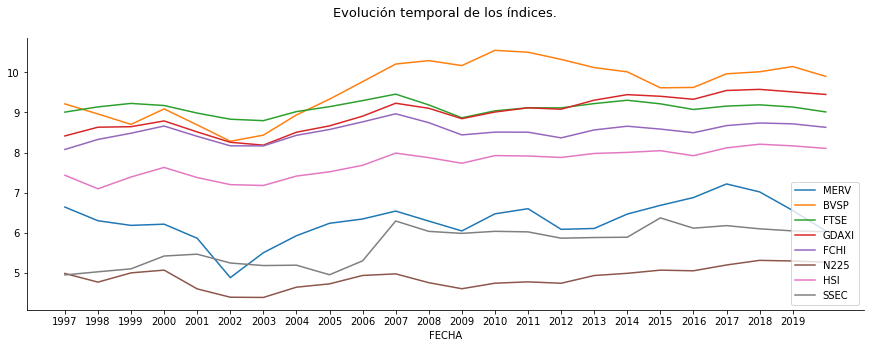

In [36]:
selected_indexes = ['MERV','BVSP','FTSE','GDAXI','FCHI','N225','HSI','SSEC']
data = series_log[selected_indexes]
new_data = data.groupby(df.index.year).mean()
ax = sns.lineplot(data=new_data, hue= ['MERV','BVSP','FTSE','GDAXI','FCHI','N225','HSI','SSEC'], dashes=False)
ax.set_xticks(np.arange(data.index.year.min(), data.index.year.max(), step=1))
sns.despine()
plt.title("Evolución temporal de los índices.\n", fontdict={'fontsize': 13})
plt.show()


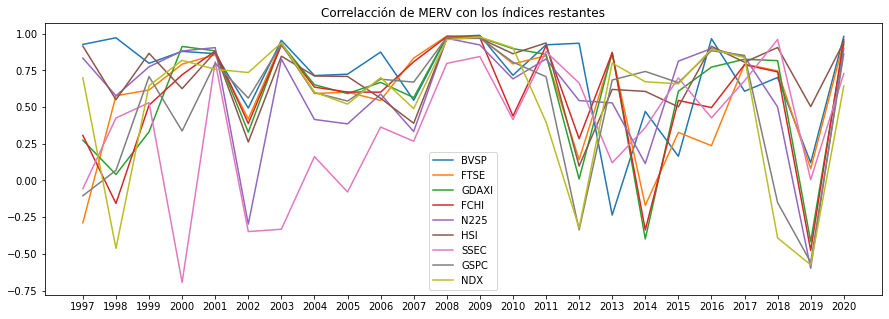

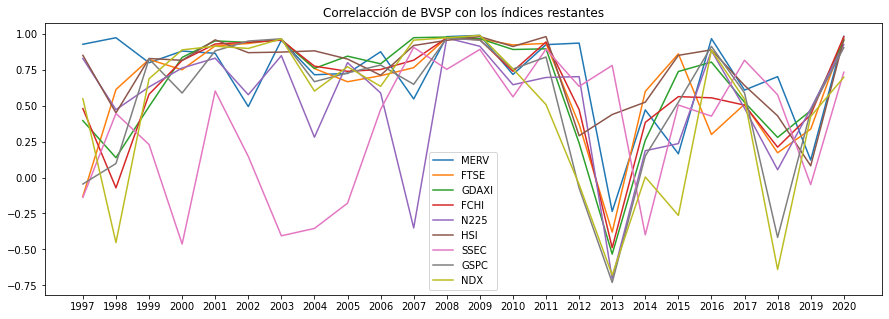

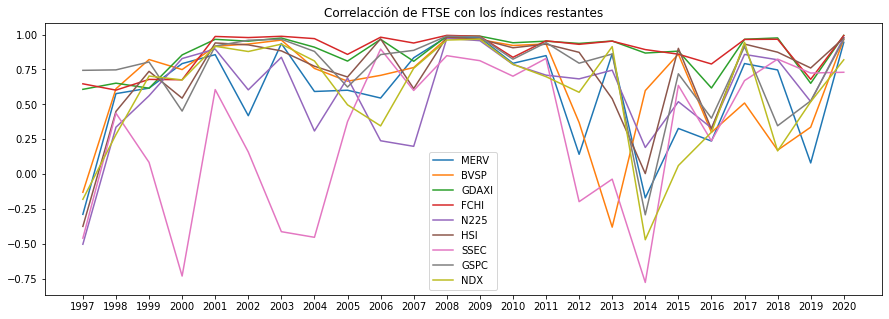

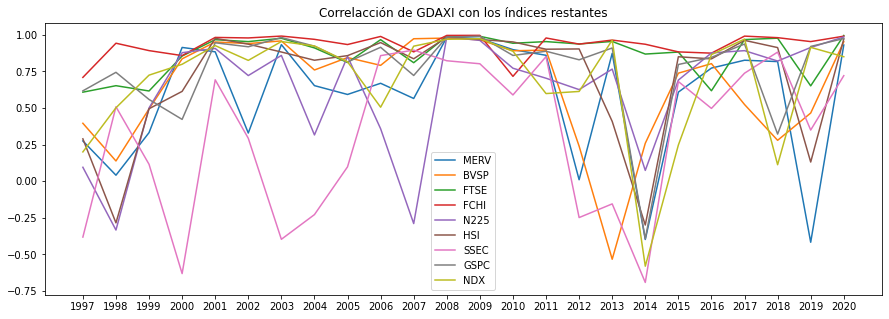

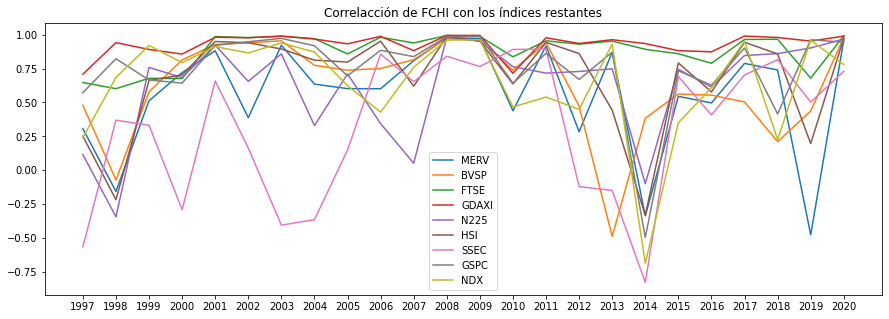

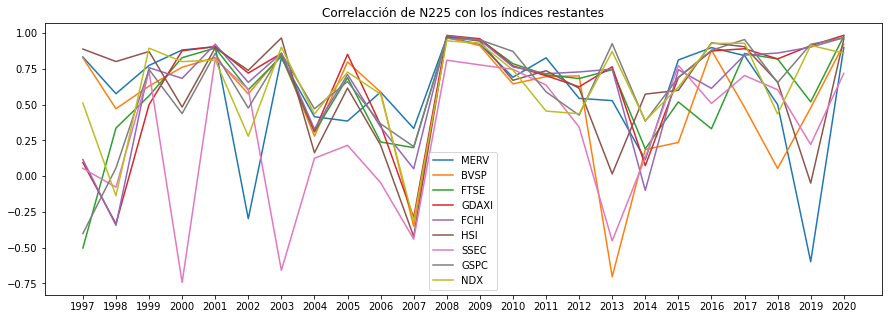

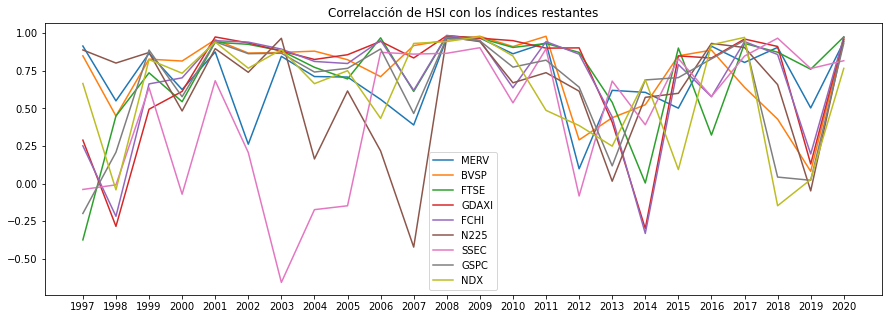

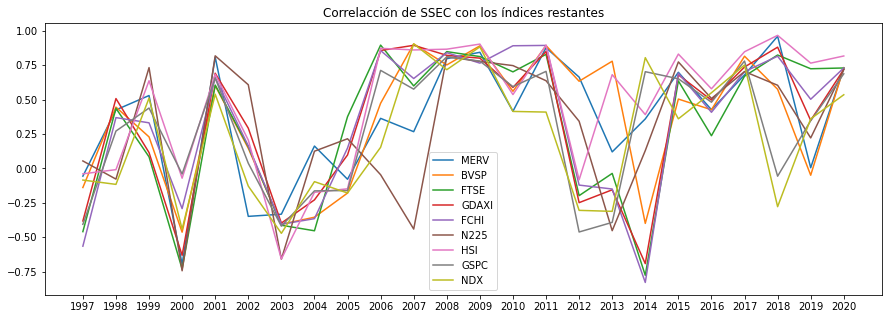

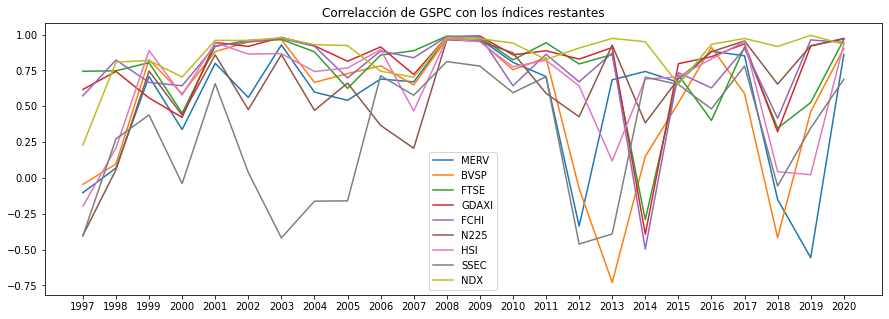

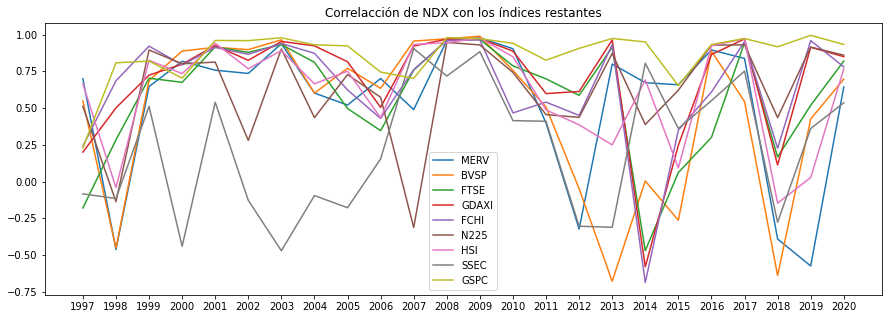

In [37]:
# Estudio de la correlacion para ver si son crisis globales o locales
df = series_log

years = [year for year in df.index.year.unique()]
for index in df.columns:
    aux = pd.DataFrame()    
    for index_ in df.columns.drop(index):
        list_corr = []
        for year in df.index.year.unique():
            corr = df[[index, index_]][df[[index, index_]].index.year == year].corr().iloc[0,1]
            list_corr.append(corr)
            
        aux['{}'.format(index_)] = list_corr
    ax = aux.plot(xticks=range(24))
    ax.set_xticklabels(years)
    plt.title('Correlacción de {} con los índices restantes'.format(index))
    del aux
    plt.show()

Del análisis anterior se concluyó lo siguiente:

- Crisis: Se observó que en el 2008-2009 el mundo sufrió una crisis global. Todos los países experimentaron una caída abrupta en este periodo y al realizar el análisis de correlación se observa que todos están juntos, lo cual significa que afectó a todos a todos los países en alguna medida.

- Crisis en Argentina: En los años 2002 y 2019, Argentina sufrió una crisis local. Esto puede verse claramente en el gráfico de correlación en el cual la Argentina se despega de los demás países.

- Evolución temporal de las series: en la mayoría de los países hubo una pequeña tendencia a aumentar el valor de su índice. Se podría trazar una débil pendiente positiva entre los valores final e inicial de los datos. En el caso de Argentina, en los últimos años el valor del índice MERV tiende a decrecer fuertemente (pendiente negativa a partir de 2017).

Por otra parte, se analizó la distribución de la tasa de rendimiento del mercado MERV vs. SSEC y FTSE, en los años 2001/2002, donde, como ya se mencionó, Argentina sufrió una crisis local:

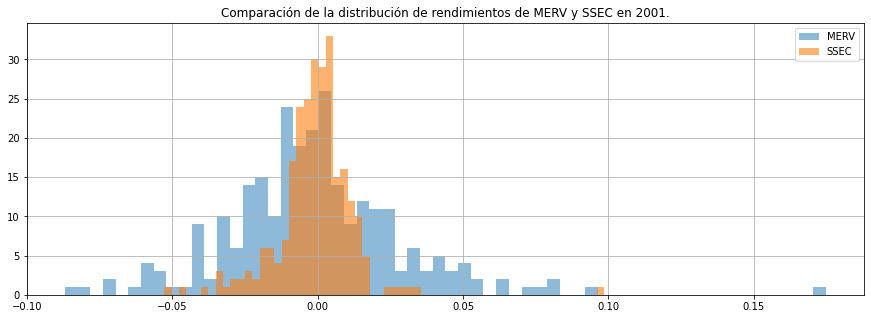

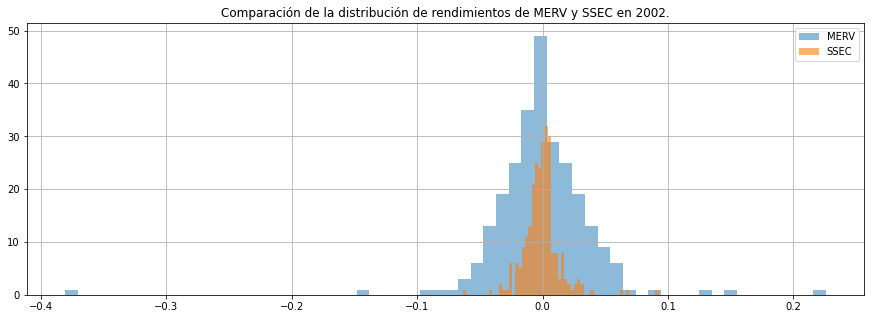

In [38]:
tasa_rend[tasa_rend.index.year ==2001].MERV.hist(bins = 60, alpha = 0.5, label = 'MERV')
tasa_rend[tasa_rend.index.year ==2001].SSEC.hist(bins = 60, alpha = 0.6, label = 'SSEC')
plt.title('Comparación de la distribución de rendimientos de MERV y SSEC en 2001.')
plt.legend()
plt.show()

tasa_rend[tasa_rend.index.year ==2002].MERV.hist(bins = 60, alpha = 0.5, label = 'MERV')
tasa_rend[tasa_rend.index.year ==2002].SSEC.hist(bins = 60, alpha = 0.6, label = 'SSEC')
plt.title('Comparación de la distribución de rendimientos de MERV y SSEC en 2002.')

plt.legend()

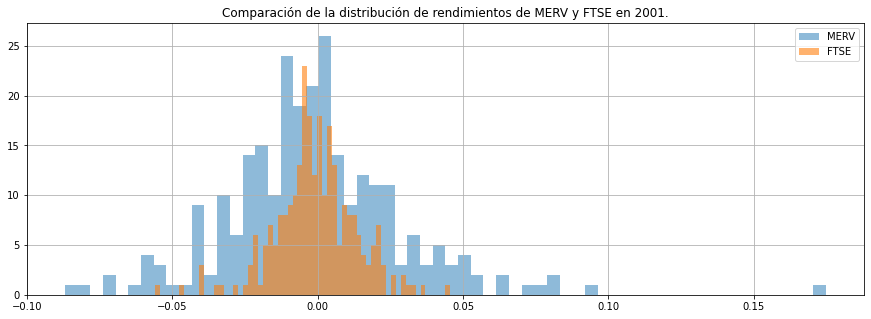

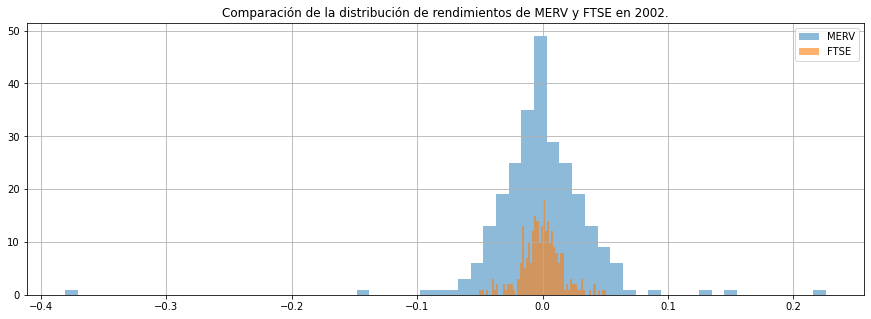

In [39]:
tasa_rend[tasa_rend.index.year ==2001].MERV.hist(bins = 60, alpha = 0.5, label = 'MERV')
tasa_rend[tasa_rend.index.year ==2001].FTSE.hist(bins = 60, alpha = 0.6, label = 'FTSE')
plt.title('Comparación de la distribución de rendimientos de MERV y FTSE en 2001.')
plt.legend()
plt.show()

tasa_rend[tasa_rend.index.year ==2002].MERV.hist(bins = 60, alpha = 0.5, label = 'MERV')
tasa_rend[tasa_rend.index.year ==2002].FTSE.hist(bins = 60, alpha = 0.6, label = 'FTSE')
plt.title('Comparación de la distribución de rendimientos de MERV y FTSE en 2002.')
plt.legend()

Queda claro en los gráficos anteriores que las colas de las distribuciones para MERV son más pesadas y es posible visualizar además algunos valores altos de rendimiento en valor absoluto. En el año 2002, se observa una marcada diferencia entre las distribuciones de MERV vs los otros. Esto se debe a que en época de crisis, los movimientos de los índices son más bruscos.

## <ins>Práctico N°3: Introducción al Aprendizaje Automático<ins>

En este práctico se persiguió el objetivo general de entrenar algunos modelos predictivos univariantes sencillos y luego comparar su desempeño. 

Se exploraron algunos modelos propios de la literatura estadística pero empleando una metodología de entrenamiento mas ligada a aprendizaje automático.
En la literatura estadística de Series Temporales se trabaja tanto con estimaciones puntuales (el pronóstico es un único número) como en la construcción de bandas de pronóstico (un rango entre los que se espera que esté el valor pronosticado con cierta probabilidad) y en la selección automática de los modelos se suelen emplear "criterios de información" tales como el de Akaike, Schwarz, Hannan-Quiin. En cambio en aprendizaje automático por lo general solo se busca efectuar una estimación puntual y para la selección de modelos (tuneo de hiperparámetros) se usan métricas predictivas. 


#### Paso 1: Redefinición de los nombres de las bases a utilizar

In [40]:
df_ret = tasa_rend
df_ln = series_log

#### Paso 2: Definición de los Modelos Predictivos Baseline 

In [41]:
def model_naive(data_X_train, data_X_test):
    
    get_prediction = data_X_train.iloc[-1]
    vector_prediction = pd.Series(index = data_X_test.index)
    vector_prediction[:]= get_prediction
 
    return vector_prediction

def model_average(data_X_train,data_X_test):
    
    get_prediction = data_X_train.mean()
    vector_prediction = pd.Series(index = data_X_test.index)
    vector_prediction[:]= get_prediction
 
    return vector_prediction

#### Paso 3: División entre datos de entrenamiento y test usando el procedimiento Walk-Forward Validation/timeSeriesSplit y Entrenamiento de Modelos

##### <ins>Entrenamiento de un modelo "baseline" para los retornos y para los logaritmos de los índices utilizando timeSeriesSplit<ins>:

In [42]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10, max_train_size=None)

In [43]:
def get_prediction_tscv(df,col):
    X = df[col]#.iloc[-300:]

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        X_pred_naive = model_naive(X_train,X_test)
        X_pred_average = model_average(X_train,X_test)

        pd.concat([X_train,X_test], axis=0).plot(color = 'green' , ls='--', label = 'Serie')
        X_pred_average.plot(color = 'blue', ls='--', label = 'Average Pred.')
        X_pred_naive.plot(color = 'red', ls='--', label= 'Naive Ped.')
        plt.legend()
        plt.show()

        print()
    return X_test, X_pred_average, X_pred_naive

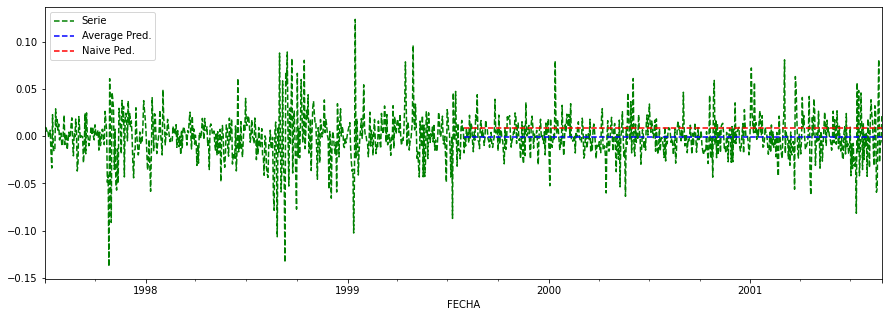

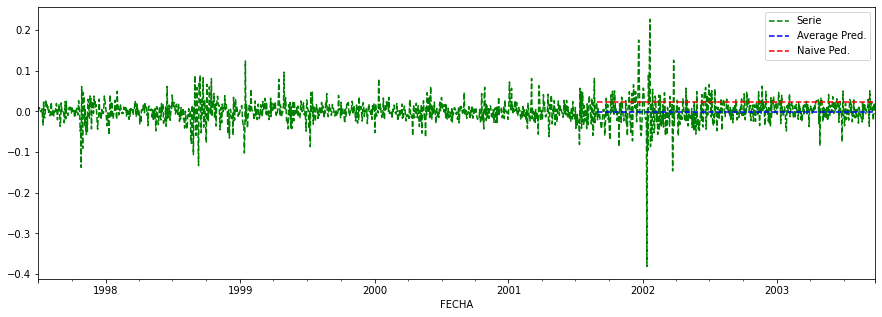

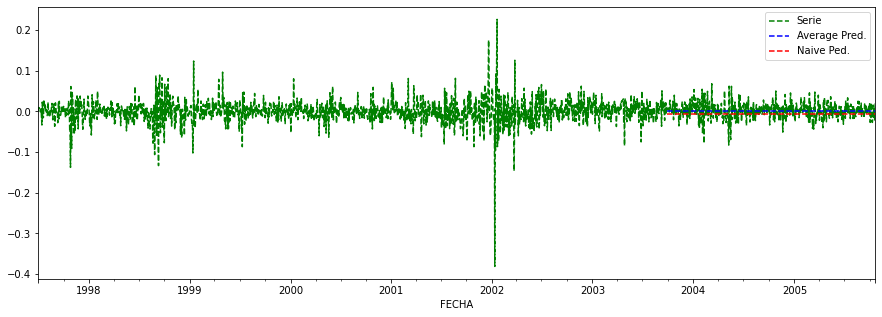

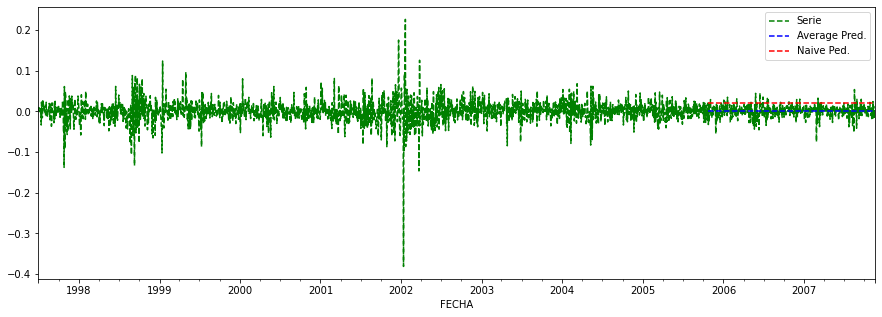

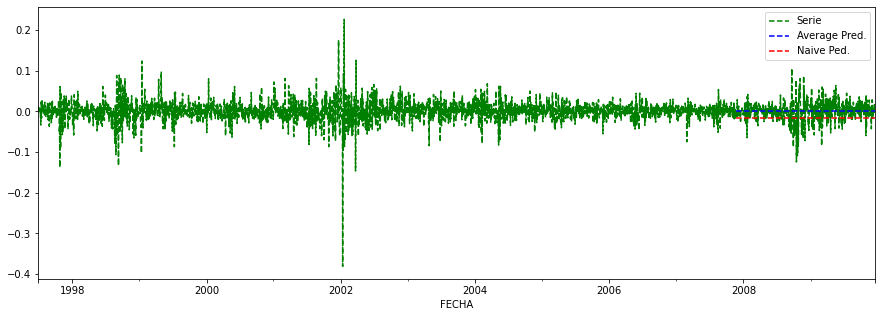

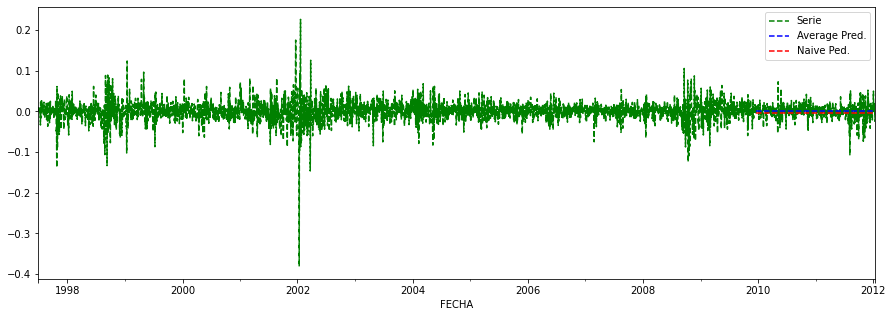

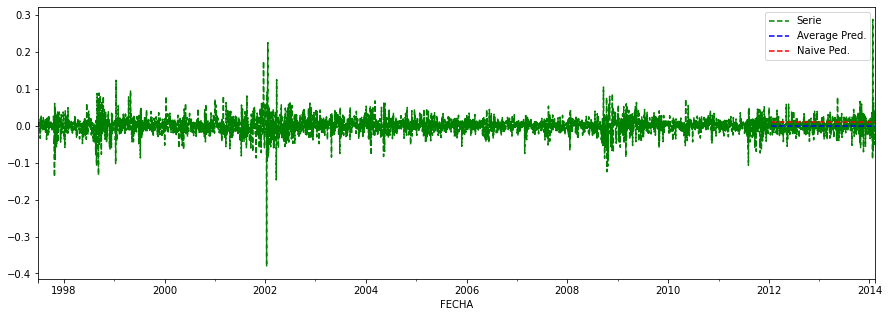

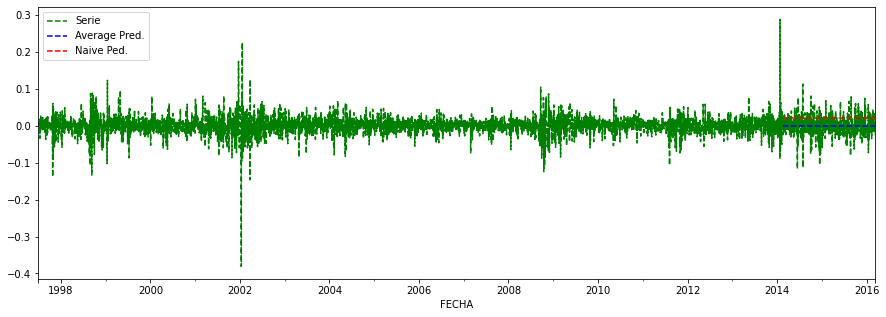

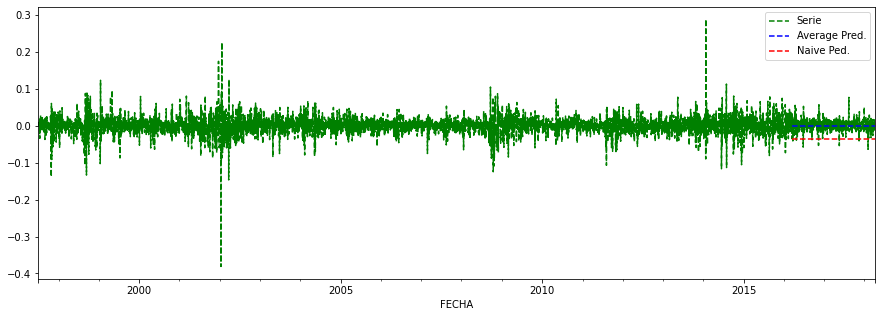

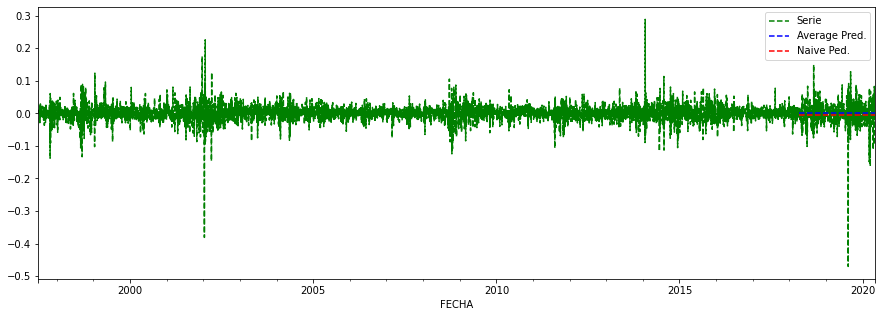

In [44]:
_,_,_ = get_prediction_tscv(df_ret,'MERV')

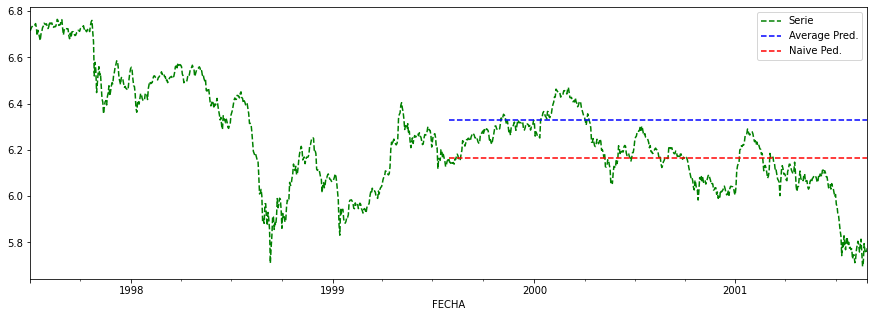

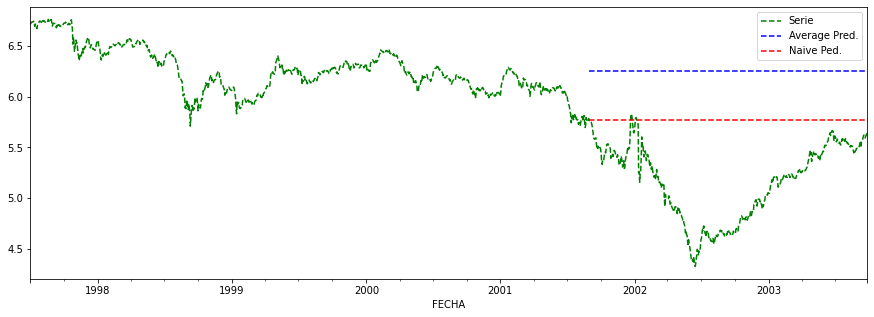

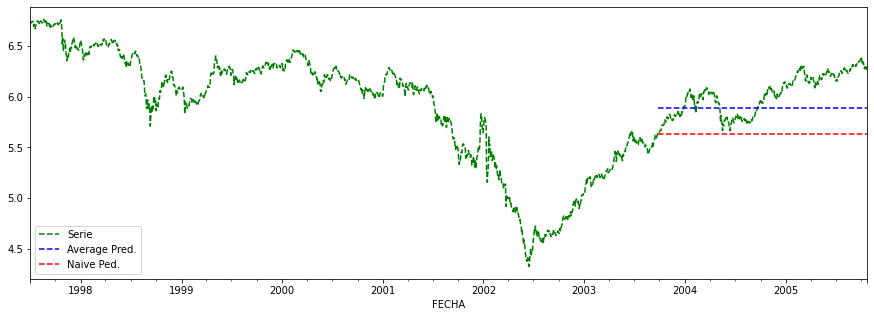

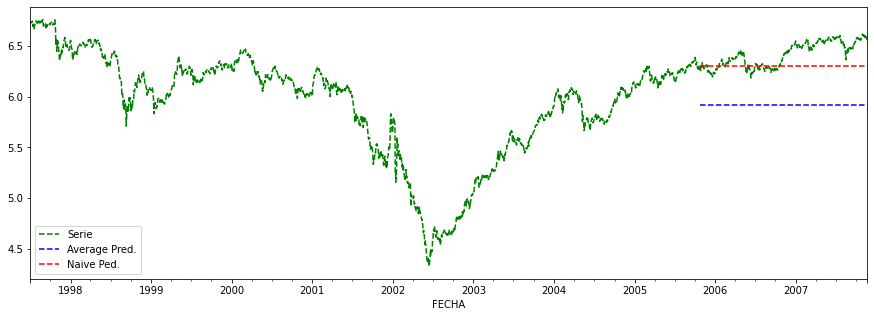

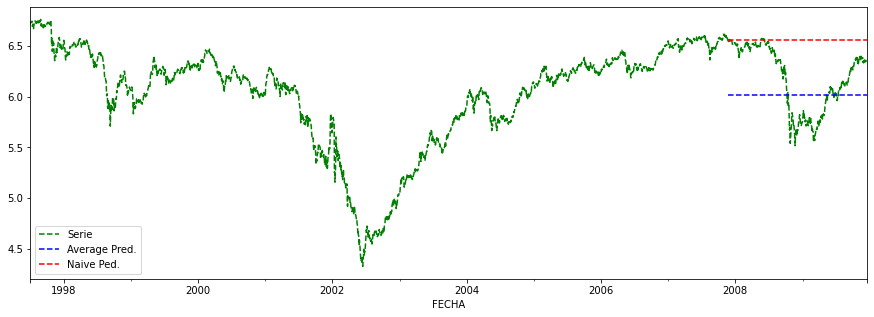

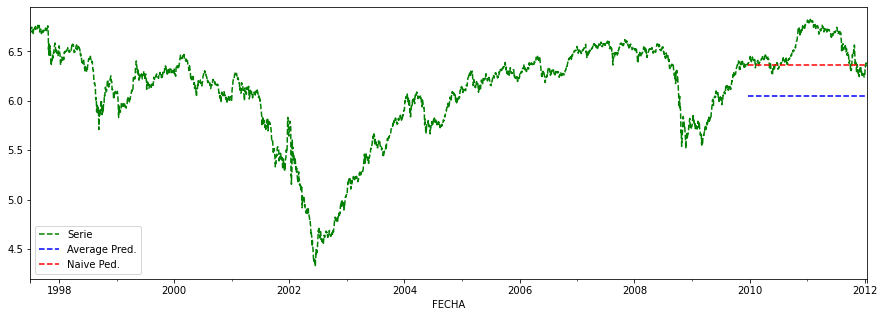

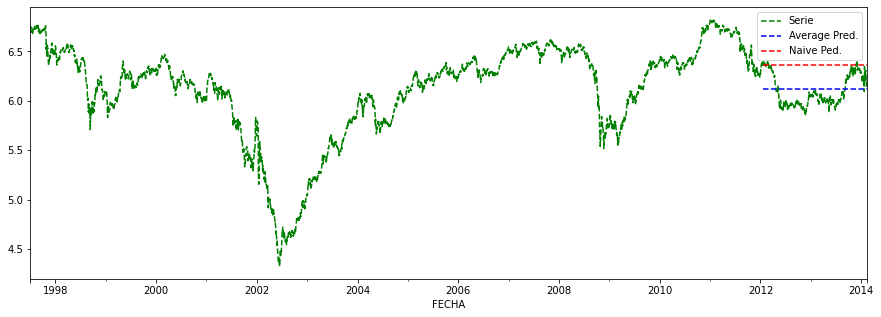

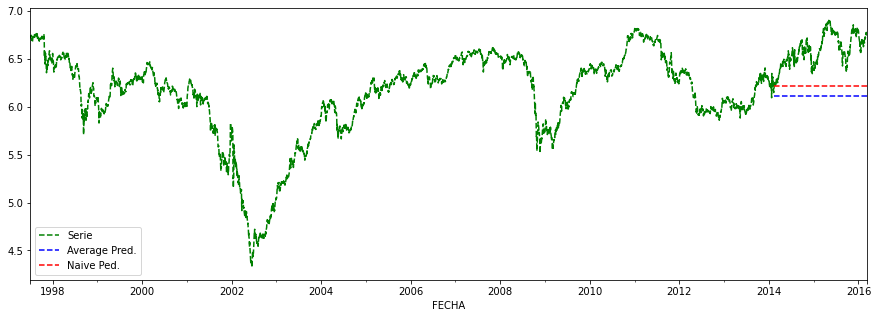

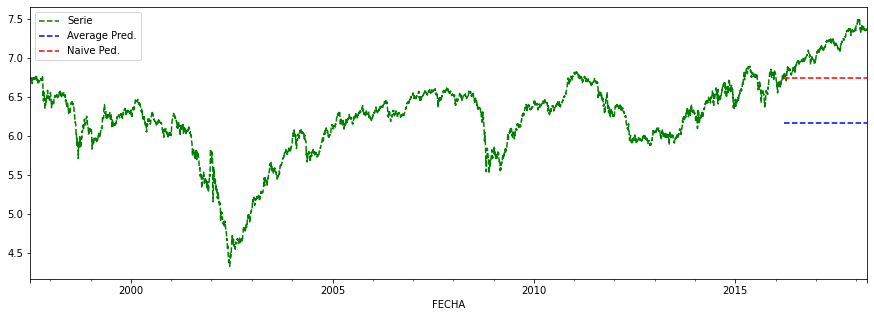

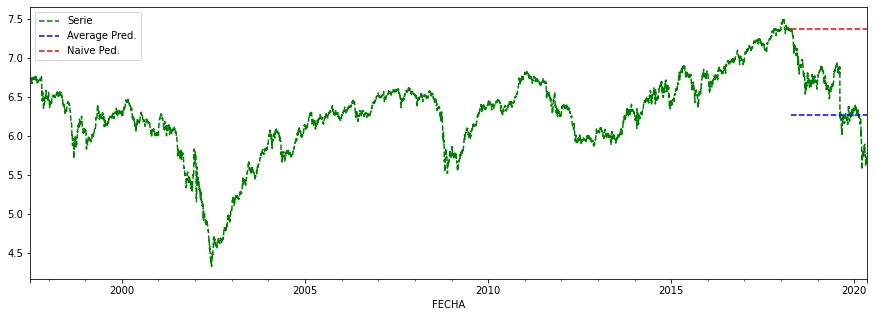

In [45]:
_,_,_ = get_prediction_tscv(df_ln,'MERV')

##### <ins>Entrenamiento de un modelo "baseline" para los retornos y para los logaritmos de los índices utilizando Walk Forward Validation<ins>:

In [46]:
class WalkForwardValidation:
    def __init__(self, df, metrics):
        self._results = {}
        self._metrics_results = {}
        self._metrics = metrics
        self.df = df
        
    def predict(self, model, target, n_train=500):
        name = f'{target}_{model.__name__}'
        X = self.df[target]
        n_records = len(X)
        self._results[name] = pd.Series()
        for i in range(n_train, n_records):
            X_train, X_test = X.iloc[0:i], X.iloc[i:i+1]
            result = model(X_train, X_test)
            self._results[name] = pd.concat([self._results[name], result])
        for metric in self._metrics:
            self._metrics_results[f'{model.__name__}_{metric.__name__}'] = metric(X[n_train:], self._results[name])
    
    @property
    def get_results(self, name=None):
        return self._results[name] if name else self._results

    def plot_results(self, configs, plot_col=None):
        for config in configs:
            name = config.pop('name')
            self._results[name].plot(**config)
        if plot_col:
            self.df[plot_col].plot(color='green' , ls='--', label = 'Serie')
        plt.legend()
        plt.show()
    
    def print_metrics(self):
        for key, value in self._metrics_results.items():
            print(key, ': ', np.round(value,5))
        print()

##### Análisis para toda la serie transformada en logaritmo:

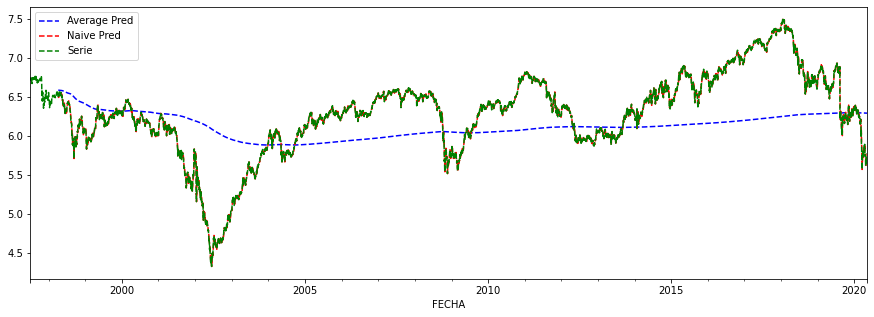

model_average_mean_squared_error :  0.28174
model_average_mean_absolute_error :  0.42556
model_average_median_absolute_error :  0.36331
model_naive_mean_squared_error :  0.00067
model_naive_mean_absolute_error :  0.01637
model_naive_median_absolute_error :  0.01121



In [47]:
# Define metrics to be used
metrics = [mean_squared_error, mean_absolute_error, median_absolute_error]

# Create a wfcv
wfcv = WalkForwardValidation(df_ln, metrics)

# Generate predictions
wfcv.predict(model_average, 'MERV', n_train=200)
wfcv.predict(model_naive, 'MERV', n_train=200)

# Plot
plot_config = [
        {'name': 'MERV_model_average', 'label': 'Average Pred', 'ls': '--', 'color': 'blue'},
        {'name': 'MERV_model_naive', 'label': 'Naive Pred', 'ls': '--', 'color': 'red'}
]
wfcv.plot_results(plot_config, plot_col='MERV')

# Show metrics
wfcv.print_metrics()

##### Análisis para un fragmento de la serie transformada en logaritmo (2019):

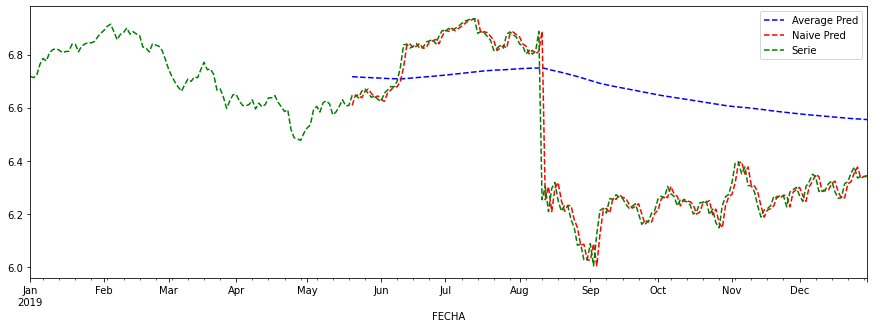

model_average_mean_squared_error :  0.1067
model_average_mean_absolute_error :  0.28315
model_average_median_absolute_error :  0.28233
model_naive_mean_squared_error :  0.00364
model_naive_mean_absolute_error :  0.02832
model_naive_median_absolute_error :  0.01495



In [48]:
# Create a wfcv
wfcv = WalkForwardValidation(df_ln[df_ln.index.year==2019], metrics)

# Generate predictions
wfcv.predict(model_average, 'MERV', n_train=100)
wfcv.predict(model_naive, 'MERV', n_train=100)

# Plot
plot_config = [
        {'name': 'MERV_model_average', 'label': 'Average Pred', 'ls': '--', 'color': 'blue'},
        {'name': 'MERV_model_naive', 'label': 'Naive Pred', 'ls': '--', 'color': 'red'}
]
wfcv.plot_results(plot_config, plot_col='MERV')

# Show metrics
wfcv.print_metrics()

##### Análisis para toda la serie de retornos:

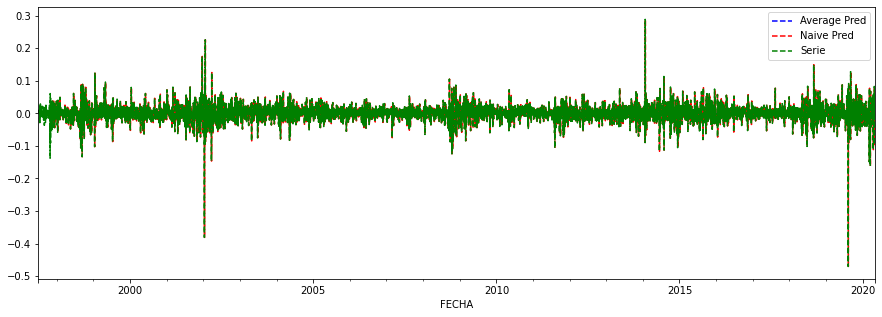

model_average_mean_squared_error :  0.00062
model_average_mean_absolute_error :  0.01629
model_average_median_absolute_error :  0.01124
model_naive_mean_squared_error :  0.00117
model_naive_mean_absolute_error :  0.02223
model_naive_median_absolute_error :  0.01542



In [49]:
# Create a wfcv
wfcv = WalkForwardValidation(df_ret, metrics)

# Generate predictions
wfcv.predict(model_average, 'MERV', n_train=100)
wfcv.predict(model_naive, 'MERV', n_train=100)


# Plot results
plot_config = [
        {'name': 'MERV_model_average', 'label': 'Average Pred', 'ls': '--', 'color': 'blue'},
        {'name': 'MERV_model_naive', 'label': 'Naive Pred', 'ls': '--', 'color': 'red'}
]
wfcv.plot_results(plot_config, plot_col='MERV')

# Show metrics
wfcv.print_metrics()

##### Análisis para un fragmento de la serie de retornos (2019):

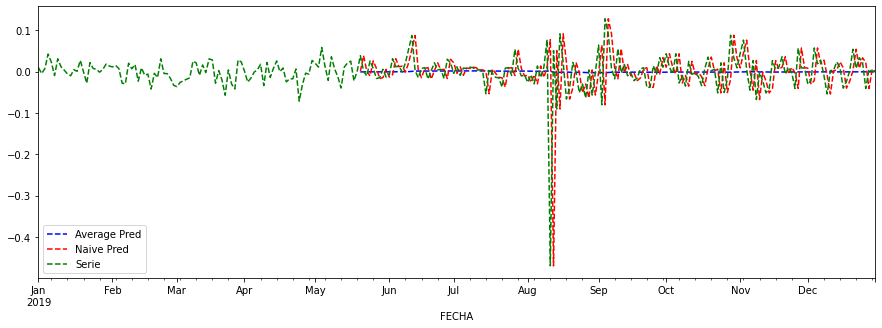

model_average_mean_squared_error :  0.00255
model_average_mean_absolute_error :  0.02741
model_average_median_absolute_error :  0.01609
model_naive_mean_squared_error :  0.00581
model_naive_mean_absolute_error :  0.04173
model_naive_median_absolute_error :  0.02581



In [50]:
# Create a wfcv
wfcv = WalkForwardValidation(df_ret[df_ret.index.year==2019], metrics)

# Generate predictions
wfcv.predict(model_average, 'MERV', n_train=100)
wfcv.predict(model_naive, 'MERV', n_train=100)


# Plot results
plot_config = [
        {'name': 'MERV_model_average', 'label': 'Average Pred', 'ls': '--', 'color': 'blue'},
        {'name': 'MERV_model_naive', 'label': 'Naive Pred', 'ls': '--', 'color': 'red'}
]
wfcv.plot_results(plot_config, plot_col='MERV')

# Show metrics
wfcv.print_metrics()

##### Conclusiones parciales

En esta parte del trabajo se entrenaron modelos base, como son el naive model y el average model. Si bien son métodos muy sencillos, estos definen un punto de referencia importante a la hora de analizar modelos más complejos. 
Hasta aquí se aplicaron los dos modelos base para las series de precios logarítmicas y de retornos. Además se calcularon diferentes métricas para comparar la performance de cada uno de los modelos para cada conjunto de datos visto. Las métricas que trabajadas fueron error cuadrático medio (mean squared error), error absoluto medio (mean_absolute_error) y error absoluto mediado (median_absolute_error)

- Cuando se trabajó con la serie de logaritmos completa (s=200 : ventana temporal inicial elegida),pudo observarse que las métricas obtenidas con el modelo naive fueron mejores que las obtenidas aplicando el modelo de los promedios. 
\begin{array}{rcc}
  & \mbox{naive} & \mbox{average} \\\hline
  \mbox{mean squared error}  &  0.00067 & 0.28174  \\\hline
  \mbox{mean absolute error}  & 0.01637 & 0.42556\\\hline
  \mbox{median absolute error}  & 0.01121 & 0.36331 \\\hline
\end{array}
Este mismo comportamiento se observó cuando se tomaron ventanas temporales más chicas (un año).

- Al trabajar con la serie de los retornos la situación anterior cambió, y el modelo que mejores valores de métricas arrojó fue el método de los promedios. A continuación se muestran los resultados arrojados para la serie completa.
\begin{array}{rcc}
  & \mbox{naive} & \mbox{average} \\\hline
  \mbox{mean squared error}  &  0.00117 & 0.00062 \\\hline
  \mbox{mean absolute error}  & 0.02223 & 0.0.01629 \\\hline
  \mbox{median absolute error}  & 0.01542 & 0.01124 \\\hline
\end{array}
Si bien la diferencia entre los valores de un modelo y otro es clara, es mucho menor que la apreciada para la serie de logaritmos. 

#### Paso 4: Creación y Entrenamiento de un Modelo ARIMA

In [51]:
series = df_ln['MERV']
X = series.values
size = int(len(X) * 0.66)

# We split the dataset into 2, 66% of the data is for training, and 34% for test
#For each prediction we do, we add the true value to the history so in each time we're training the model with the newest values
train, test = X[0:size], X[size:len(X)] 
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    # If you wanna see the predicted and true values, just uncomment the code above
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.001


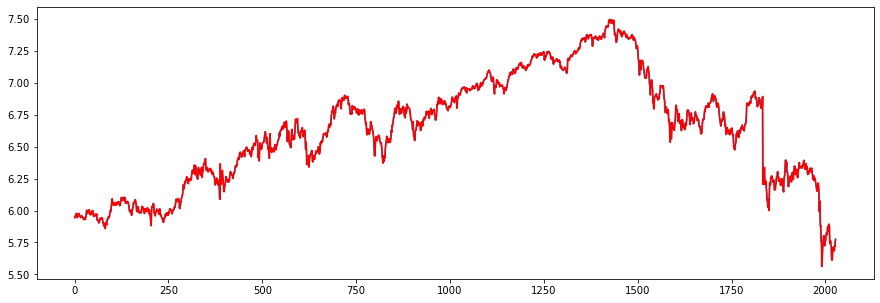

In [91]:
#Plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## <ins>Práctico N°4: Aprendizaje Supervisado<ins>

El objetivo principal del práctico fue estimar modelos relativamente más avanzados a los expuestos anteriormente y comparar su desempeño con los trabajados previamente. Se propuso trabajar con los modelos VAR, VECM y LSTM.

#### Paso 1: Split de Datos en Train, Test y Validation

In [92]:
target = 'MERV'

In [93]:
def percentage_split_data(data, percentage_val, percentage_test):
    percentage_train = 100 - percentage_val - percentage_test

    total_rows = len(data.index)
    train_rows = int(round(total_rows * percentage_train / 100))
    val_rows = int(round(total_rows * percentage_val / 100))
    test_rows = int(round(total_rows * percentage_test / 100))
    
    train_data = data[:train_rows]
    val_data = data[train_rows:-test_rows]
    test_data = data[-test_rows:]

    return train_data, val_data, test_data

In [94]:
ret_train_data, ret_val_data, ret_test_data = percentage_split_data(df_ret, 10, 20)
ln_train_data, ln_val_data, ln_test_data = percentage_split_data(df_ln, 10, 20)

n_test = len(ret_test_data.index)

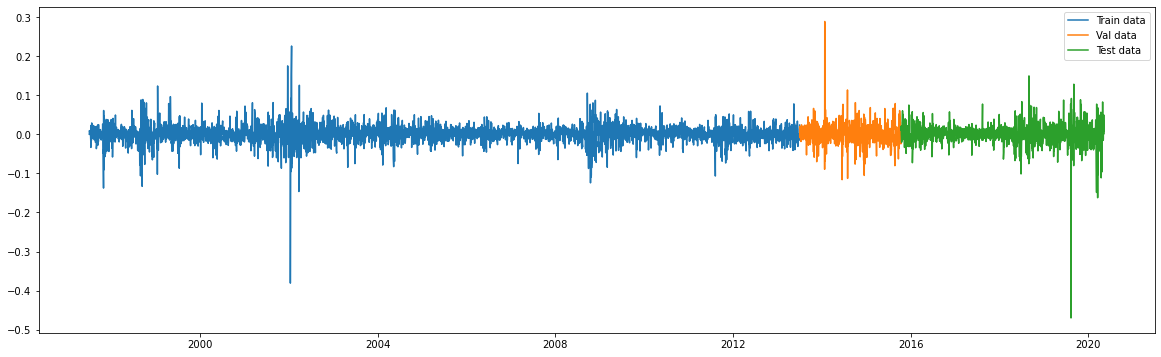

In [95]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ret_train_data.index,ret_train_data[target], label='Train data')
ax.plot(ret_val_data.index, ret_val_data[target], label='Val data')
ax.plot(ret_test_data.index, ret_test_data[target], label='Test data')
ax.legend()
plt.show()

#### Paso 2: Modelo VAR

Los modelos vectoriales autorregresivos (VAR) que son la extensión natural de los modelos ARMA para series multivariantes. Empleando los mismos se pueden modelar las tasas de rendimiento de varios índices financieros en forma simultánea. 

Formalmente, Se conoce como modelo de vectores autorregresivos a un proceso estocástico $k$-dimensional $x_t$ tal que

$$x_t= A_1 x_{t-1} +...+A_p x_{t-p} + u_t,$$

donde las $A_i$, para $i= 1,...,p$, son matrices de orden $k \times k$ y $u_t$ es un proceso ruido blanco de dimensión $k$; o sea que $E(u_t)=0$, $E(u_t u_t') = \Sigma_u$ y $E(u_tu_s)=0$ para $s \neq t$.

##### <ins>Definición de funcion que calcula el MSE pasado un max lags usando los datos de validación<ins>:

In [96]:
def get_var_mse(max_lags:int, col):
    var_model = VAR(ret_train_data)
    var_model_results = var_model.fit(maxlags=max_lags)
    var_model_lag_order = var_model_results.k_ar
    var_model_forecast_input_data = ret_val_data.values[-var_model_lag_order:]
    var_model_pred = var_model_results.forecast(y=var_model_forecast_input_data, steps=len(ret_val_data.index))
    var_model_pred = (pd.DataFrame(var_model_pred, index=ret_val_data.index, columns=ret_val_data.columns + '_pred'))
    mse = mean_squared_error(ret_val_data[col], var_model_pred[f'{col}_pred'])
    return mse

In [99]:
results = pd.DataFrame(columns=['max_lags', 'mse'])
for max_lags in range(10, 21):
    mse = get_var_mse(max_lags, target)
    results = results.append({'max_lags': max_lags, 'mse': mse}, ignore_index=True)
ordered_results = results.sort_values(by=['mse', 'max_lags']).reset_index(drop=True)
ordered_results

max_lags       mse
0       20.0  0.000843
1       19.0  0.000844
2       17.0  0.000844
3       16.0  0.000844
4       18.0  0.000844
5       13.0  0.000844
6       12.0  0.000844
7       14.0  0.000845
8       10.0  0.000845
9       11.0  0.000845
10      15.0  0.000845

##### <ins>Búsqueda del mejor max lags<ins>:

In [100]:
best_max_lags = ordered_results.iloc[0]['max_lags']
best_max_lags = int(best_max_lags)
best_max_lags

20

##### <ins>Predicción del valor en los datos de test<ins>:

In [101]:
var_model = VAR(ret_train_data)
var_model_results = var_model.fit(maxlags=best_max_lags)
var_model_lag_order = var_model_results.k_ar
var_model_forecast_input_data = ret_test_data.values[-var_model_lag_order:]
var_model_pred = var_model_results.forecast(y=var_model_forecast_input_data, steps=len(ret_test_data.index))
var_model_pred = (pd.DataFrame(var_model_pred, index=ret_test_data.index, columns=ret_test_data.columns + '_pred'))
mse = mean_squared_error(ret_test_data[target], var_model_pred[f'{target}_pred'])

In [102]:
var_model_pred

MERV_pred  BVSP_pred  FTSE_pred  GDAXI_pred  FCHI_pred  N225_pred  \
FECHA                                                                           
2015-10-14   0.006393   0.003734  -0.005430    0.005483   0.005814   0.003654   
2015-10-15  -0.004483  -0.011284  -0.004921   -0.000705   0.000764  -0.002974   
2015-10-16  -0.007829  -0.007852  -0.011873   -0.007347  -0.006387  -0.008465   
2015-10-19   0.014939   0.025942  -0.008895   -0.001732  -0.003365   0.008893   
2015-10-20   0.003131  -0.007333  -0.003741   -0.006051  -0.003410  -0.007114   
...               ...        ...        ...         ...        ...        ...   
2020-05-04   0.000079   0.000460   0.000143    0.000338   0.000240   0.000073   
2020-05-05   0.000079   0.000460   0.000143    0.000338   0.000240   0.000073   
2020-05-06   0.000079   0.000460   0.000143    0.000338   0.000240   0.000073   
2020-05-07   0.000079   0.000460   0.000143    0.000338   0.000240   0.000073   
2020-05-08   0.000079   0.000460   0.000143    0.000338   0.000240   0.000073   

            HSI_pred  SSEC_pred  GSPC_pred  NDX_pred  
FECHA                                                 
2015-10-14  0.029056   0.008791   0.006816  0.001043  
2015-10-15 -0.003469  -0.007610  -0.002179 -0.006194  
2015-10-16 -0.008339   0.007196  -0.011774 -0.016271  
2015-10-19  0.007100   0.010052   0.000126  0.001718  
2015-10-20 -0.007685   0.000680  -0.003178 -0.003579  
...              ...        ...        ...       ...  
2020-05-04  0.000213   0.000320   0.000215  0.000434  
2020-05-05  0.000213   0.000320   0.000215  0.000434  
2020-05-06  0.000213   0.000320   0.000215  0.000434  
2020-05-07  0.000213   0.000320   0.000215  0.000434  
2020-05-08  0.000213   0.000320   0.000215  0.000434  

[1193 rows x 10 columns]

##### <ins>Cálculo de las métricas para los datos de test<ins>:

In [105]:
# Mean absolute error
mae = mean_absolute_error(ret_test_data[target], var_model_pred[f'{target}_pred'])
print('MAE: %f' % mae)

# Mean squared error
mse = mean_squared_error(ret_test_data[target], var_model_pred[f'{target}_pred'])
print('MSE: %f' % mse)

# Root mean squared error
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 0.018192
MSE: 0.000861
RMSE: 0.029338


#### Paso 3: Modelo VECM

En caso de estimar modelos para series no estacionarias, como es el caso de los logaritmos naturales de los retornos, los modelos VAR no son adecuados por razones similares a las estudiadas en el caso de los modelos ARIMA. Se podría aplicar un modelo VAR para las series diferenciadas, pero para no perder la información sobre las potenciales relaciones de largo plazo entre dichas series es recomendable trabajar con modelos vectoriales de corrección de errores (VECM). 

Formalmente:

Dado el modelo VAR no estacionario (o sea que las series componetes de $y_t$ son no estacionarias) $$y_t= A_1 y_{t-1}+...+A_p y_{t-p}+ u_t,$$

el mismo puede ser reescrito en forma de Modelo de Corrección de Errores (VECM) $$\Delta y_t=\Pi y_{t-1}+ \Gamma_1 \Delta y_{t-1}+...+\Gamma_p \Delta y_{t-p+1}+ u_t.$$

Siendo  $\Pi = -(I_k - A_1 - ... - A_p)$, $r(\Pi)= r$, con $0 \leq r \leq k$, $u_t \sim N(0, \Sigma_u)$ y las $\Gamma_i=-(A_{i+1}+...+A_p)$, para $i=1,...,p-1$ son matrices de parámetros de orden $k \times k$. Si $\Pi$ tiene rango $r$, puede ser expresada como el producto $\alpha \beta'$, siendo $\alpha$ y $\beta$ matrices de orden $k\times r$ de rango $r$. En dicho caso, se dice que el proceso $y_t$ es cointegrado con rango $r$. Las matrices $\beta$ y $\alpha$ son conocidas como matriz de cointegración y matriz de cargas, respectivamente.

La importancia de la representación en forma de modelo de correción de errores radica en que permite expresar a $\Delta y_t$ como la suma de dos componentes (aparte de $u_t$): 1) $\Pi y_{t-1}$ que muestra relaciones de equilibrio de largo plazo y 2) $\Gamma_1 \Delta y_{t-1}+...+\Gamma_p \Delta y_{t-p+1}$ que capta el ajuste de corto plazo.

Respecto a las relaciones de largo plazo, las mismas son conocidas como relaciones de cointegración y consisten en combinaciones lineales estacionarias $z_t=\beta'y_t$ de las series $y_t$ (las cuales son no estacionarias).


##### <ins>Test de Johansen<ins>:

Para conocer la cantidad de relaciones de cointegración (el 3er hiperparámetro del modelo VECM), se realizó el Test de Johansen.
El valor de medida, ya sea max_eigenvalue o trace_stat, debe ser mayor al valor crítico para poder rechazar la hipótesis nula que el número de correlaciones es menor o igual a n.

In [107]:
data = df_ln

from statsmodels.tsa.vector_ar.vecm import coint_johansen

"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""

def joh_output(res):
    output = pd.DataFrame([res.lr1, res.lr2],
                          index=["trace_stat", 'max_eig_stat'])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat")
    for i in range(len(res.cvt)):
        print(i, res.cvt[i])
    print("\n")
    print("Critical values(90%, 95%, 99%) of max_eig_stat")
    for i in range(len(res.cvm)):
        print(i, res.cvm[i])
    print("--------------------------------------------------------------")


# Model 3 (2 lag-difference used = 3 lags VAR or VAR(3) model)
# with constant/trend (deterministc) term
joh_model3 = coint_johansen(data,0,2) # k_ar_diff +1 = K
joh_output(joh_model3)
# Model 2: with linear trend only
joh_model2 = coint_johansen(data,1,2) # k_ar_diff +1 = K
joh_output(joh_model2)

# Model 1: no constant/trend (deterministc) term
joh_model1 = coint_johansen(data,-1,2) # k_ar_diff +1 = K
joh_output(joh_model1)

   trace_stat  max_eig_stat
0  222.994557     60.226823
1  162.767733     46.488569
2  116.279164     41.612700
3   74.666464     19.875803
4   54.790661     17.547156
5   37.243506     14.252003
6   22.991503      9.973592
7   13.017911      6.896086
8    6.121825      5.475145
9    0.646680      0.646680 

Critical values(90%, 95%, 99%) of trace_stat
0 [232.103  239.2468 253.2526]
1 [190.8714 197.3772 210.0366]
2 [153.6341 159.529  171.0905]
3 [120.3673 125.6185 135.9825]
4 [ 91.109   95.7542 104.9637]
5 [65.8202 69.8189 77.8202]
6 [44.4929 47.8545 54.6815]
7 [27.0669 29.7961 35.4628]
8 [13.4294 15.4943 19.9349]
9 [2.7055 3.8415 6.6349]


Critical values(90%, 95%, 99%) of max_eig_stat
0 [61.2041 64.504  71.2525]
1 [55.2412 58.4332 64.996 ]
2 [49.2855 52.3622 58.6634]
3 [43.2947 46.2299 52.3069]
4 [37.2786 40.0763 45.8662]
5 [31.2379 33.8777 39.3693]
6 [25.1236 27.5858 32.7172]
7 [18.8928 21.1314 25.865 ]
8 [12.2971 14.2639 18.52  ]
9 [2.7055 3.8415 6.6349]
---------------------------

##### <ins>Forma Alternativa de Evaluar Test de Johansen<ins>:

In [108]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
vec_rank1 = select_coint_rank(ln_train_data, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(vec_rank1.summary())
vec_rank2 = select_coint_rank(ln_train_data, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
print(vec_rank2.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0  10          305.7          273.4
  1  10          211.2          228.2
-------------------------------------
Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          94.45          74.74
  1   2          51.81          68.50
-------------------------------------


##### <ins>Determinación hiperparámetros con los datos de Validación<ins>:

In [109]:
def get_hiperp(hiperp:int, col):
    model = VECM(endog = ln_train_data, k_ar_diff = hiperp, coint_rank = 1)
    model_results = model.fit()
    model_pred = model_results.predict(steps=len(ln_val_data.index))
    model_pred = (pd.DataFrame(model_pred, index=ln_val_data.index, columns=ln_val_data.columns + '_pred'))

    # Mean squared error
    mse = mean_squared_error(ln_val_data[col], model_pred[f'{col}_pred'])
    return mse

In [110]:
results = pd.DataFrame(columns=['hiperp', 'mse'])
for hiperp in range(1, 20):
    mse = get_hiperp(hiperp, target)
    results = results.append({'hiperp': hiperp, 'mse': mse}, ignore_index=True)
ordered_results = results.sort_values(by=['mse', 'hiperp']).reset_index(drop=True)
ordered_results

hiperp       mse
0     19.0  0.288589
1     16.0  0.293410
2     15.0  0.297737
3     14.0  0.297993
4     17.0  0.302300
5     18.0  0.302946
6      2.0  0.330694
7     11.0  0.331764
8     12.0  0.335164
9      1.0  0.335547
10     7.0  0.335583
11     8.0  0.338565
12     6.0  0.338565
13     3.0  0.341608
14     4.0  0.342760
15    13.0  0.344134
16    10.0  0.348591
17     5.0  0.350947
18     9.0  0.352620

In [111]:
best_hiperp = ordered_results.iloc[0]['hiperp']
best_hiperp = int(hiperp)
hiperp

19

In [112]:
new_train = pd.concat([ln_train_data, ln_val_data])

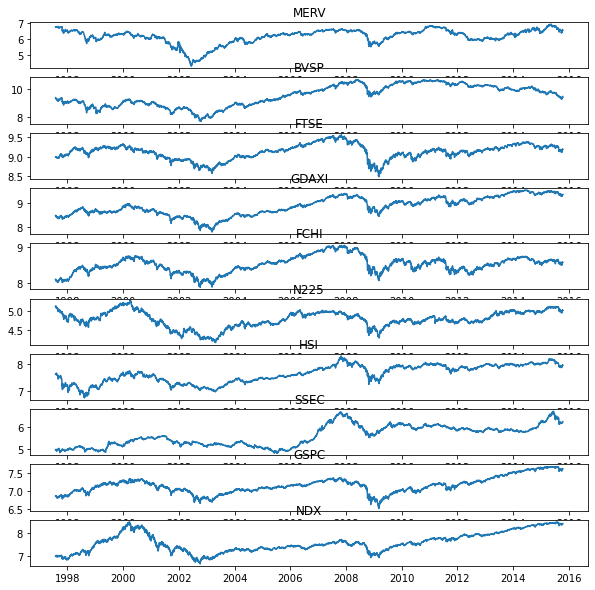

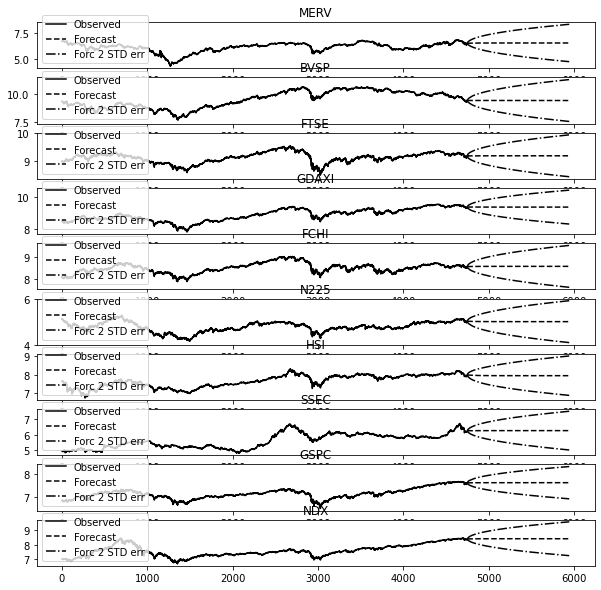

In [113]:
model = VECM(endog = new_train, k_ar_diff = hiperp, coint_rank = 1)
model_results = model.fit()
model_results.plot_data()
model_results.plot_forecast(n_test)

In [114]:
model_pred = model_results.predict(steps=n_test)
model_pred = (pd.DataFrame(model_pred, index=ln_test_data.index, columns=ln_test_data.columns + '_pred'))

model_pred

MERV_pred  BVSP_pred  FTSE_pred  GDAXI_pred  FCHI_pred  N225_pred  \
FECHA                                                                           
2015-10-14   6.531624   9.420186   9.176588    9.343516   8.572624   5.021618   
2015-10-15   6.532922   9.420740   9.176463    9.342741   8.571803   5.020628   
2015-10-16   6.541177   9.423720   9.176576    9.341627   8.570558   5.017511   
2015-10-19   6.545018   9.432740   9.180256    9.345152   8.572883   5.018548   
2015-10-20   6.546581   9.436888   9.184676    9.346067   8.575760   5.019787   
...               ...        ...        ...         ...        ...        ...   
2020-05-04   6.573759   9.449445   9.185564    9.344838   8.585583   5.008786   
2020-05-05   6.573759   9.449445   9.185564    9.344838   8.585583   5.008786   
2020-05-06   6.573759   9.449445   9.185564    9.344838   8.585583   5.008786   
2020-05-07   6.573759   9.449445   9.185564    9.344838   8.585583   5.008786   
2020-05-08   6.573759   9.449445   9.185564    9.344838   8.585583   5.008786   

            HSI_pred  SSEC_pred  GSPC_pred  NDX_pred  
FECHA                                                 
2015-10-14  7.976022   6.257701   7.605491  8.377604  
2015-10-15  7.973685   6.256471   7.603797  8.377489  
2015-10-16  7.972878   6.255330   7.602590  8.376355  
2015-10-19  7.974026   6.253993   7.603196  8.377432  
2015-10-20  7.975631   6.250704   7.604398  8.376159  
...              ...        ...        ...       ...  
2020-05-04  7.940856   6.265872   7.614590  8.402624  
2020-05-05  7.940856   6.265872   7.614590  8.402624  
2020-05-06  7.940856   6.265872   7.614590  8.402624  
2020-05-07  7.940856   6.265872   7.614590  8.402624  
2020-05-08  7.940856   6.265872   7.614590  8.402624  

[1193 rows x 10 columns]

In [115]:
# Mean absolute error
mae = mean_absolute_error(ln_test_data['MERV'], model_pred['MERV_pred'])
print('MAE: %f' % mae)

# Mean squared error
mse = mean_squared_error(ln_test_data['MERV'], model_pred['MERV_pred'])
print('MSE: %f' % mse)

# Root mean squared error
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 0.406636
MSE: 0.223839
RMSE: 0.473117


Analizando las métricas de error de los modelos Baseline (Average y Naive) para la serie de logaritmos (ver abajo), se observa que no es posible mejorar las predicciones de dichos modelos base.

1. model_average_mean_squared_error :  0.28174
2. model_average_mean_absolute_error :  0.42556
3. model_average_median_absolute_error :  0.36331
4. model_naive_mean_squared_error :  0.00067
5. model_naive_mean_absolute_error :  0.01637
6. model_naive_median_absolute_error :  0.01121

#### Paso 4: Modelo LSTM Univariante

##### <ins>Normalización de los Datos<ins>:

In [116]:
#Dividimos la muestra
df = df_us[['MERV']].copy()

# Split data into train and test
train, test = df.iloc[0:-200], df.iloc[-200:len(df)]

train_max = train.max()
train_min = train.min()

# Normalize the dataframes
train = (train - train_min)/(train_max - train_min)
test = (test - train_min)/(train_max - train_min)

##### <ins>Estructuración de los Datos<ins>:

In [118]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 10

X_train, y_train = create_dataset(train, train.MERV, time_steps)
X_test, y_test = create_dataset(test, test.MERV, time_steps)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    shuffle=False
)